<a href="https://colab.research.google.com/github/jamesaycheese/MSDS_453_A1/blob/main/MSDS453_Assignment_02_v25_20241025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## **MSDS453 - Research Assignment 02 - Classification and Clustering**

Clustering methods compute a similarity (or closeness) measure, such as Euclidean distance, in order to decide whether two documents are ‘similar’ or not.  

Use the entire class corpus and do sentiment analysis for the positive and negative reviews.

Topic modeling is another way to group ‘similar’ documents into ‘clusters’.

# **1. Modules and Loading Data Set via Google Drive**

In [30]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

### Mount Google Drive to Colab Environment

<div class="alert alert-block alert-success">
    <b>Directories Required for Research Assignment</b>:<br>
1. Data Directory - Source Class Corpus Data<br>
2. Output Directory - Vocabulary<br>
</div>

#### Uncomment To Map Google Drive

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


&nbsp;

# **2. NLTK Downloads, etc, Data Wrangling Utility Functions, and Loading the Corpus**

In [32]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [33]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.3


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [34]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [35]:
# COMMENTED OUT FUNCTIONS HERE NOT REFERENCED BY OTHER PARTS OF NOTEBOOK

def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

@dataclass
class Document:
    doc_id: str
    text: str

# def normalize_document(document: Document) -> Document:
#     text = document.text
#     text = remove_punctuation(text)
#     text = lower_case(text)
#     text = remove_tags(text)
#     text = remove_special_chars_and_digits(text)

#     return Document(document.doc_id, text)

# def normalize_documents(documents: List[Document]) -> List[Document]:
#     """
#     Normalizes text for all given documents.
#     Removes punctuation, converts to lower case, removes tags and special characters.
#     """
#     return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

# def tokenize_document(document: Document) -> TokenizedDocument:
#     tokens = nltk.word_tokenize(document.text)
#     return TokenizedDocument(document.doc_id, tokens)

# def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
#     return [tokenize_document(x) for x in documents]

# def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
#     result = []
#     lemmatizer = WordNetLemmatizer()
#     for document in documents:
#         output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
#         result.append(TokenizedDocument(document.doc_id, output_tokens))
#
#     return result

# def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
#     result = []
#     stemmer = PorterStemmer()
#     for document in documents:
#         output_tokens = [stemmer.stem(w) for w in document.tokens]
#         result.append(TokenizedDocument(document.doc_id, output_tokens))
#
#     return result

# def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
#     result = []
#
#     stop_words = set(nltk.corpus.stopwords.words('english'))
#     for document in documents:
#         filtered_tokens = [w for w in document.tokens if not w in stop_words]
#         result.append(TokenizedDocument(document.doc_id, filtered_tokens))
#
#     return result

# def add_flags(data: pd.DataFrame, casino_royale_doc_ids: List[int], action_doc_ids: List[int]):
#     data['is_casino_royale'] = data.index.isin(casino_royale_doc_ids)
#     data['is_action'] = data.index.isin(action_doc_ids)

# def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
#     tokens = {y for x in documents for y in x.tokens}
#     return sorted(list(tokens))

def clean_doc(doc):
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # word stemming
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

# def final_processed_text_disabled(doc):
#     #this is a function to join the processed text back
#     ' '.join(doc)
#     return doc

def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)

    #creating datafram from TFIDF Matrix

    # https://stackoverflow.com/questions/70215049/attributeerror-tfidfvectorizer-object-has-no-attribute-get-feature-names-out
    #words = Tfidf.get_feature_names() # For sklearn <= 0.24.x
    #matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

    words = Tfidf.get_feature_names_out() # For sklearn >= 1.0.x
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names_out(), index=titles)
    return matrix #,words

def One_Hot(variable):
    #this is a function to one hot encode the classes
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels

&nbsp;

# **3. Functions Latent Semantic Analysis, Latent Dirichlet Allocation, Word2Vec Matrix**
1. Latent Semantic Analysis
2. Latent Dirichlet Allocation
3. Word2Vec Matrix creation

In [36]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    # train model
    lsamodel = LsiModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,power_iters=100)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index

def lsa(tfidf_matrix, terms, n_components = 10):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.

    LSA = TruncatedSVD(n_components=10)
    LSA.fit(tfidf_matrix)

    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])

def create_gensim_lda_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    ldamodel = LdaModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,alpha='auto'
                        ,eta='auto'
                        ,iterations=100
                        ,random_state=23
                        ,passes=20)
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
    return ldamodel,dictionary,index,doc_term_matrix

def lda(tfidf_matrix, terms, topics = 3, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    topics = 3
    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)

def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the
    #tokenized text and matrix size

    #word to vec
    model_w2v = Word2Vec(processed_text, vector_size=100, window=5, min_count=1, workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]
    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors={}

    #for loop to obtain weights for each word
    for i in w2v_words:
        temp_vec=model_w2v.wv[i]
        w2v_vectors[i]=temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    print(w2v_df)
    return w2v_df

## This code below is Experimental#1 and Barry wants your feedback if this works or not

In [37]:
## Experimental#1 code here will show you the movie titles for the topics
## Uncomment all the code in this cell and it will override the above functions
## Also switch ot the modified Experiment#1 code lines elsewhere to add the "titles" parameter
## or you can ignore the commented lines for Experiment#1 code and continue your assignment.

def create_gensim_lda_model(doc_clean,number_of_topics,words, titles):

    dictionary = corpora.Dictionary(doc_clean)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    ldamodel = LdaModel(doc_term_matrix ,num_topics=number_of_topics,id2word = dictionary,alpha='auto',
                                          eta='auto',iterations=100,random_state=23,passes=20)
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])

    # THIS CODE BELOW IS EXPERIMENTAL#1 AND BARRY WANTS YOUR FEEDBACK IF THIS WORKS OR NOT

    # Method 1: Shows top 5 titles related to a topic; adjust the number accordingly.
    for topic in ldamodel.print_topics(num_topics=number_of_topics, num_words=words):
        topic_number = topic[0]
        sims = index[ldamodel[doc_term_matrix[topic_number]]]
        most_similar_titles = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])[:5]]
        print('Most similar titles for topic #{}: {}'.format(topic_number, most_similar_titles))

    # Method 2: Shows all titles sorted on most similar for each topic.
    # Note you get all titles for all topics!

    for document in doc_clean:
        doc_bow = dictionary.doc2bow(document)
        sims = index[ldamodel[doc_bow]]
        most_similar_topic = sorted(enumerate(sims), key=lambda item: -item[1])[0][0]
        #VERBOSE DEBUGGING: print('Document belongs to topic #{}'.format(most_similar_topic))

    topic_titles = {}
    for topic_number, topic in enumerate(ldamodel.print_topics(num_topics=number_of_topics, num_words=words)):
        sims = index[ldamodel[doc_term_matrix[topic_number]]]
        titles_for_topic = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])]
        topic_titles[topic_number] = titles_for_topic
        print('Titles for topic #{}: {}'.format(topic_number, titles_for_topic))

    return ldamodel,dictionary,index,doc_term_matrix

##########

def create_gensim_lsa_model(doc_clean, number_of_topics, words, titles):

    dictionary = corpora.Dictionary(doc_clean)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word=dictionary, power_iters=100)

    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    # THIS CODE BELOW IS EXPERIMENTAL AND BARRY WANTS YOUR FEEDBACK IF THIS WORKS OR NOT

    # Method 1: Shows top 5 titles related to a topic; adjust the number accordingly.
    for topic in lsamodel.print_topics(num_topics=number_of_topics, num_words=words):
        topic_number = topic[0]
        sims = index[lsamodel[doc_term_matrix[topic_number]]]
        most_similar_titles = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])[:5]]
        print('Most similar titles for topic #{}: {}'.format(topic_number, most_similar_titles))

    # Method 2: Shows all titles sorted on most similar for each topic.
    # Note you get all titles for all topics!

    for document in doc_clean:
        doc_bow = dictionary.doc2bow(document)
        sims = index[lsamodel[doc_bow]]
        most_similar_topic = sorted(enumerate(sims), key=lambda item: -item[1])[0][0]
        #VERBOSE DEBUGGING: print('Document belongs to topic #{}'.format(most_similar_topic))

    topic_titles = {}
    for topic_number, topic in enumerate(lsamodel.print_topics(num_topics=number_of_topics, num_words=words)):
        sims = index[lsamodel[doc_term_matrix[topic_number]]]
        titles_for_topic = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])]
        topic_titles[topic_number] = titles_for_topic
        print('Titles for topic #{}: {}'.format(topic_number, titles_for_topic))

    return lsamodel, dictionary, index

############
##
## When you call create_gensim_lda_model(...) later on, you have to add titles to the call. Eg:
##
## model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words,titles)
##
## Similarly for LSA...

# **4. Modeling Functions: KMeans, SVM, Logistic, Naive Bayes, Randomforest, BERTopic**

In [38]:
def k_means(titles, tfidf_matrix, k=3):

    #this is a function to generate the k-means output using the tfidf matrix.  Inputs
    #to the function include: titles of text, processed text, and desired k value.
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    # How to see the results of the k-means clustering
    print ("cluster_title", cluster_title)
    print ("clusters", clusters)
    print ("frame", frame)
    return cluster_title,clusters,frame

def bert_pretrained(texts):
    # Initialize the classifier
    classifier = pipeline("sentiment-analysis")

    # Perform sentiment analysis
    results = []
    for text in texts:
        # Since the classifier can only handle a certain amount of text,
        # you might need to truncate or split the text accordingly.
        result = classifier(text[:512])  # Adjust if necessary
        results.append(result)

    return results

def classifiers(x, y, model_type, cv = 3):

    #this function is to fit 3 different model scenarios.  Support vector machines, logistic regressions, naive bayes.
    #svm = Support vector machin
    #logistic = Logistic regression
    #naive_bayes = Naive Bayes Multinomial

    #can define cv value for cross validation.

    #function returns the train test split scores of each model.

    if model_type == 'svm':
        print("svm")
        model = SVC()

    elif model_type == 'logistic':
        print("logistic")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("naive_bayes")
        model = MultinomialNB()

    elif model_type == 'randomforest':
        print("randomforest")
        model = RandomForestClassifier()

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=23)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    accy = accuracy_score(y_test, predictions)
    return accy

## Visualization Utility Functions

## Loading the Class Corpus

In [39]:
def plot_lsa(number_of_topics, words,titles):

    # BARRYC experimental#1
    model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words,titles)
    #model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(30, 10))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()
    return model

def plot_tfidf_matrix(cluster_title,clusters,TFIDF_matrix):
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    dist = 1 - cosine_similarity(TFIDF_matrix)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]


    #set up colors per clusters using a dict.  number of colors must correspond to K
    cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick',
                      5:'red', 6:'darksalmon', 7:'sienna'}

    #set up cluster names using a dict.
    cluster_dict=cluster_title

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters))))

    #group by cluster
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20,20)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:

        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)

        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_dict[name], color=color,
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='on')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='on')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})      #show legend with only 1 point

In [40]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_NLP/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec56_v1_20241003.csv'
data = get_corpus_df(CORPUS_PATH)

In [41]:
#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text'].tolist()

1. Dataframe = corpus_df
2. List = documents (Document ID, Text)

&nbsp;

# **5. Exploratory Data Analysis**

In [42]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_NLP/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec56_v1_20241003.csv'
corpus_df = get_corpus_df(CORPUS_PATH)
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

In [43]:
corpus_df.shape

(200, 9)

In [44]:
corpus_df.head().T

Doc_ID                                                                  166  \
DSI_Title                             PLW_Doc6_Kingsman__The_Secret_Service   
Submission File Name                  PLW_Doc6_Kingsman__The_Secret_Service   
Student Name                                                            PLW   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                    Kingsman__The_Secret_Service   
Text                      One complaint that has always dogged the James...   
Descriptor                        Action_Kingsman__The_Secret_Service_N_166   
Doc_ID                                                                  166   

Doc_ID                                                                  167  \
DSI_Title                             PLW_Doc7_Kingsman__The_Secret_Service   
Submission File Name                  PLW_Doc7_Kingsman__The_Secret_Service   
Student Name                                                            PLW   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                    Kingsman__The_Secret_Service   
Text                      The main reason Kingsman: The Secret Service l...   
Descriptor                        Action_Kingsman__The_Secret_Service_N_167   
Doc_ID                                                                  167   

Doc_ID                                                                  168  \
DSI_Title                             PLW_Doc8_Kingsman__The_Secret_Service   
Submission File Name                  PLW_Doc8_Kingsman__The_Secret_Service   
Student Name                                                            PLW   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                    Kingsman__The_Secret_Service   
Text                      "Kingsman: The Secret Service" makes up its ow...   
Descriptor                        Action_Kingsman__The_Secret_Service_N_168   
Doc_ID                                                                  168   

Doc_ID                                                                  169  \
DSI_Title                             PLW_Doc9_Kingsman__The_Secret_Service   
Submission File Name                  PLW_Doc9_Kingsman__The_Secret_Service   
Student Name                                                            PLW   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                    Kingsman__The_Secret_Service   
Text                      Silly, sadistic and finally a little galling, ...   
Descriptor                        Action_Kingsman__The_Secret_Service_N_169   
Doc_ID                                                                  169   

Doc_ID                                                                  170  
DSI_Title                            PLW_Doc10_Kingsman__The_Secret_Service  
Submission File Name                 PLW_Doc10_Kingsman__The_Secret_Service  
Student Name                                                            PLW  
Genre of Movie                                                       Action  
Review Type (pos or neg)                                           Negative  
Movie Title                                    Kingsman__The_Secret_Service  
Text                      "The Spy Who Amused Me," James Bond, has abdic...  
Descriptor                        Action_Kingsman__The_Secret_Service_N_170  
Doc_ID                                                                  170

In [45]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 166 to 269
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Submission File Name      200 non-null    object
 2   Student Name              200 non-null    object
 3   Genre of Movie            200 non-null    object
 4   Review Type (pos or neg)  200 non-null    object
 5   Movie Title               200 non-null    object
 6   Text                      200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 15.6+ KB
None


In [46]:
print(corpus_df['Movie Title'].unique())

['Kingsman__The_Secret_Service' 'No_Time_to_Die' 'Taken'
 'The_Batman(2022)' 'Top_Gun' 'Barbie' 'Dirty_Grandpa' 'Lost_City'
 'Mean_Girls' 'Scott_Pilgrim_vs._the_World' 'Drag_Me_To_Hell' 'Fresh'
 'It_Chapter_Two' 'The_Conjuring_2' 'The_Others' 'Equilibirum' 'Inception'
 'Minority_Report' 'Oblivion' 'Pitch_Black']


Exploring different numbers of...


> LSA: **2**, **6**, **20** concepts and **10** words<br>
> LDA: **2**, **6**, **20** topics and **10** words<br>

1.   *Model Complexity*
2.   *Model Interpretability*
3.   *Evaluation of Coherence*
4.   *Avoid Overfitting*
5.   *Practical Implications*
6.   *Computational Implications*


## Latent Semantic Analysis - Research Number of Topics and Number of Words

### Plotting 2 concepts and 10 words

In [47]:
titles = ['PLW_Doc6_Kingsman__The_Secret_Service', 'PLW_Doc7_Kingsman__The_Secret_Service', 'PLW_Doc8_Kingsman__The_Secret_Service', 'PLW_Doc9_Kingsman__The_Secret_Service', 'PLW_Doc10_Kingsman__The_Secret_Service', 'PLW_Doc1_Kingsman__The_Secret_Service', 'PLW_Doc2_Kingsman__The_Secret_Service', 'PLW_Doc3_Kingsman__The_Secret_Service', 'PLW_Doc4_Kingsman__The_Secret_Service', 'PLW_Doc5_Kingsman__The_Secret_Service', 'UIY_Doc6_No_Time_to_Die', 'UIY_Doc7_No_Time_to_Die', 'UIY_Doc8_No_Time_to_Die', 'UIY_Doc9_No_Time_to_Die', 'UIY_Doc10_No_Time_to_Die', 'UIY_Doc1_No_Time_to_Die', 'UIY_Doc2_No_Time_to_Die', 'UIY_Doc3_No_Time_to_Die', 'UIY_Doc4_No_Time_to_Die', 'UIY_Doc5_No_Time_to_Die', 'AGA_Doc6_Taken', 'AGA_Doc7_Taken', 'AGA_Doc8_Taken', 'AGA_Doc9_Taken', 'AGA_Doc10_Taken', 'AGA_Doc1_Taken', 'AGA_Doc2_Taken', 'AGA_Doc3_Taken', 'AGA_Doc4_Taken', 'AGA_Doc5_Taken', 'FZI_Doc2_The_Batman(2022)', 'FZI_Doc7_The_Batman(2022)', 'FZI_Doc8_The_Batman(2022)', 'FZI_Doc9_The_Batman(2022)', 'FZI_Doc10_The_Batman(2022)', 'FZI_Doc1_The_Batman(2022)', 'FZI_Doc3_The_Batman(2022)', 'FZI_Doc4_The_Batman(2022)', 'FZI_Doc5_The_Batman(2022)', 'FZI_Doc6_The_Batman(2022)', 'ZEO_Doc6_Top_Gun', 'ZEO_Doc7_Top_Gun', 'ZEO_Doc8_Top_Gun', 'ZEO_Doc9_Top_Gun', 'ZEO_Doc10_Top_Gun', 'ZEO_Doc1_Top_Gun', 'ZEO_Doc2_Top_Gun', 'ZEO_Doc3_Top_Gun', 'ZEO_Doc4_Top_Gun', 'ZEO_Doc5_Top_Gun', 'BCD_Doc6_Barbie', 'BCD_Doc7_Barbie', 'BCD_Doc8_Barbie', 'BCD_Doc9_Barbie', 'BCD_Doc10_Barbie', 'BCD_Doc1_Barbie', 'BCD_Doc2_Barbie', 'BCD_Doc3_Barbie', 'BCD_Doc4_Barbie', 'BCD_Doc5_Barbie', 'WJC_Doc1_Dirty_Grandpa', 'WJC_Doc2_Dirty_Grandpa', 'WJC_Doc4_Dirty_Grandpa', 'WJC_Doc8_Dirty_Grandpa', 'WJC_Doc9_Dirty_Grandpa', 'WJC_Doc3_Dirty_Grandpa', 'WJC_Doc5_Dirty_Grandpa', 'WJC_Doc6_Dirty_Grandpa', 'WJC_Doc7_Dirty_Grandpa', 'WJC_Doc10_Dirty_Grandpa', 'TPB_Doc2_Lost_City', 'TPB_Doc4_Lost_City', 'TPB_Doc6_Lost_City', 'TPB_Doc7_Lost_City', 'TPB_Doc8_Lost_City', 'TPB_Doc1_Lost_City', 'TPB_Doc3_Lost_City', 'TPB_Doc5_Lost_City', 'TPB_Doc9_Lost_City', 'TPB_Doc10_Lost_City', 'SMA_Doc1_Mean_Girls', 'SMA_Doc2_Mean_Girls', 'SMA_Doc3_Mean_Girls', 'SMA_Doc4_Mean_Girls', 'SMA_Doc5_Mean_Girls', 'SMA_Doc6_Mean_Girls', 'SMA_Doc7_Mean_Girls', 'SMA_Doc8_Mean_Girls', 'SMA_Doc9_Mean_Girls', 'SMA_Doc10_Mean_Girls', 'YXT_Doc3_Scott_Pilgrim_vs._the_World', 'YXT_Doc4_Scott_Pilgrim_vs._the_World', 'YXT_Doc5_Scott_Pilgrim_vs._the_World', 'YXT_Doc6_Scott_Pilgrim_vs._the_World', 'YXT_Doc8_Scott_Pilgrim_vs._the_World', 'YXT_Doc1_Scott_Pilgrim_vs._the_World', 'YXT_Doc2_Scott_Pilgrim_vs._the_World', 'YXT_Doc7_Scott_Pilgrim_vs._the_World', 'YXT_Doc9_Scott_Pilgrim_vs._the_World', 'YXT_Doc10_Scott_Pilgrim_vs._the_World', 'UCT_Doc6_Drag_Me_To_Hell', 'UCT_Doc7_Drag_Me_To_Hell', 'UCT_Doc8_Drag_Me_To_Hell', 'UCT_Doc9_Drag_Me_To_Hell', 'UCT_Doc10_Drag_Me_To_Hell', 'UCT_Doc1_Drag_Me_To_Hell', 'UCT_Doc2_Drag_Me_To_Hell', 'UCT_Doc3_Drag_Me_To_Hell', 'UCT_Doc4_Drag_Me_To_Hell', 'UCT_Doc5_Drag_Me_To_Hell', 'CWM_Doc6_Fresh', 'CWM_Doc7_Fresh', 'CWM_Doc8_Fresh', 'CWM_Doc9_Fresh', 'CWM_Doc10_Fresh', 'CWM_Doc1_Fresh', 'CWM_Doc2_Fresh', 'CWM_Doc3_Fresh', 'CWM_Doc4_Fresh', 'CWM_Doc5_Fresh', 'GLQ_Doc6_It_Chapter_Two', 'GLQ_Doc7_It_Chapter_Two', 'GLQ_Doc8_It_Chapter_Two', 'GLQ_Doc9_It_Chapter_Two', 'GLQ_Doc10_It_Chapter_Two', 'GLQ_Doc1_It_Chapter_Two', 'GLQ_Doc2_It_Chapter_Two', 'GLQ_Doc3_It_Chapter_Two', 'GLQ_Doc4_It_Chapter_Two', 'GLQ_Doc5_It_Chapter_Two', 'JCN_Doc4_The_Conjuring_2', 'JCN_Doc5_The_Conjuring_2', 'JCN_Doc6_The_Conjuring_2', 'JCN_Doc7_The_Conjuring_2', 'JCN_Doc8_The_Conjuring_2', 'JCN_Doc1_The_Conjuring_2', 'JCN_Doc2_The_Conjuring_2', 'JCN_Doc3_The_Conjuring_2', 'JCN_Doc9_The_Conjuring_2', 'JCN_Doc10_The_Conjuring_2', 'XXE_Doc6_The_Others', 'XXE_Doc7_The_Others', 'XXE_Doc8_The_Others', 'XXE_Doc9_The_Others', 'XXE_Doc10_The_Others', 'XXE_Doc1_The_Others', 'XXE_Doc2_The_Others', 'XXE_Doc3_The_Others', 'XXE_Doc4_The_Others', 'XXE_Doc5_The_Others', 'RJE_Doc2_Equilibirum', 'RJE_Doc7_Equilibirum', 'RJE_Doc8_Equilibirum', 'RJE_Doc9_Equilibirum', 'RJE_Doc10_Equilibirum', 'RJE_Doc1_Equilibirum', 'RJE_Doc3_Equilibirum', 'RJE_Doc4_Equilibirum', 'RJE_Doc5_Equilibirum', 'RJE_Doc6_Equilibirum', 'QJK_Doc6_Inception', 'QJK_Doc7_Inception', 'QJK_Doc8_Inception', 'QJK_Doc9_Inception', 'QJK_Doc10_Inception', 'QJK_Doc1_Inception', 'QJK_Doc2_Inception', 'QJK_Doc3_Inception', 'QJK_Doc4_Inception', 'QJK_Doc5_Inception', 'MWS_Doc6_Minority_Report', 'MWS_Doc7_Minority_Report', 'MWS_Doc8_Minority_Report', 'MWS_Doc9_Minority_Report', 'MWS_Doc10_Minority_Report', 'MWS_Doc1_Minority_Report', 'MWS_Doc2_Minority_Report', 'MWS_Doc3_Minority_Report', 'MWS_Doc4_Minority_Report', 'MWS_Doc5_Minority_Report', 'PYC_Doc6_Oblivion', 'PYC_Doc7_Oblivion', 'PYC_Doc8_Oblivion', 'PYC_Doc9_Oblivion', 'PYC_Doc10_Oblivion', 'PYC_Doc1_Oblivion', 'PYC_Doc2_Oblivion', 'PYC_Doc3_Oblivion', 'PYC_Doc4_Oblivion', 'PYC_Doc5_Oblivion', 'DHZ_Doc1_Pitch_Black', 'DHZ_Doc3_Pitch_Black', 'DHZ_Doc6_Pitch_Black', 'DHZ_Doc8_Pitch_Black', 'DHZ_Doc10_Pitch_Black', 'DHZ_Doc2_Pitch_Black', 'DHZ_Doc4_Pitch_Black', 'DHZ_Doc5_Pitch_Black', 'DHZ_Doc7_Pitch_Black', 'DHZ_Doc9_Pitch_Black']

[(0, '0.531*"movie" + 0.149*"films" + 0.148*"movies" + 0.142*"character" + 0.139*"story" + 0.128*"characters" + 0.127*"horror" + 0.122*"action" + 0.120*"first" + 0.115*"barbie"'), (1, '0.806*"barbie" + 0.161*"world" + -0.144*"movie" + 0.140*"gerwig" + 0.132*"gosling" + 0.124*"robbie" + 0.120*"barbies" + 0.120*"margot" + -0.111*"batman" + 0.090*"girls"')]
Most similar titles for topic #0: ['PLW_Doc6_Kingsman__The_Secret_Service', 'SMA_Doc2_Mean_Girls', 'YXT_Doc7_Scott_Pilgrim_vs._the_World', 'RJE_Doc8_Equilibirum', 'YXT_Doc2_Scott_Pilgrim_vs._the_World']
Most similar titles for topic #1: ['PLW_Doc7_Kingsman__The_Secret_Service', 'FZI_Doc3_The_Batman(2022)', 'CWM_Doc7_Fresh', 'WJC_Doc4_Dirty_Grandpa', 'UIY_Doc7_No_Time_to_Die']
Titles for topic #0: ['PLW_Doc6_Kingsman__The_Secret_Service', 'SMA_Doc2_Mean_Girls', 'YXT_Doc7_Scott_Pilgrim_vs._the_World', 'RJE_Doc8_Equilibirum', 'YXT_Doc2_Scott_Pilgrim_vs._the_World', 'YXT_Doc5_Scott_Pilgrim_vs._the_World', 'YXT_Doc9_Scott_Pilgrim_vs._the_Wo

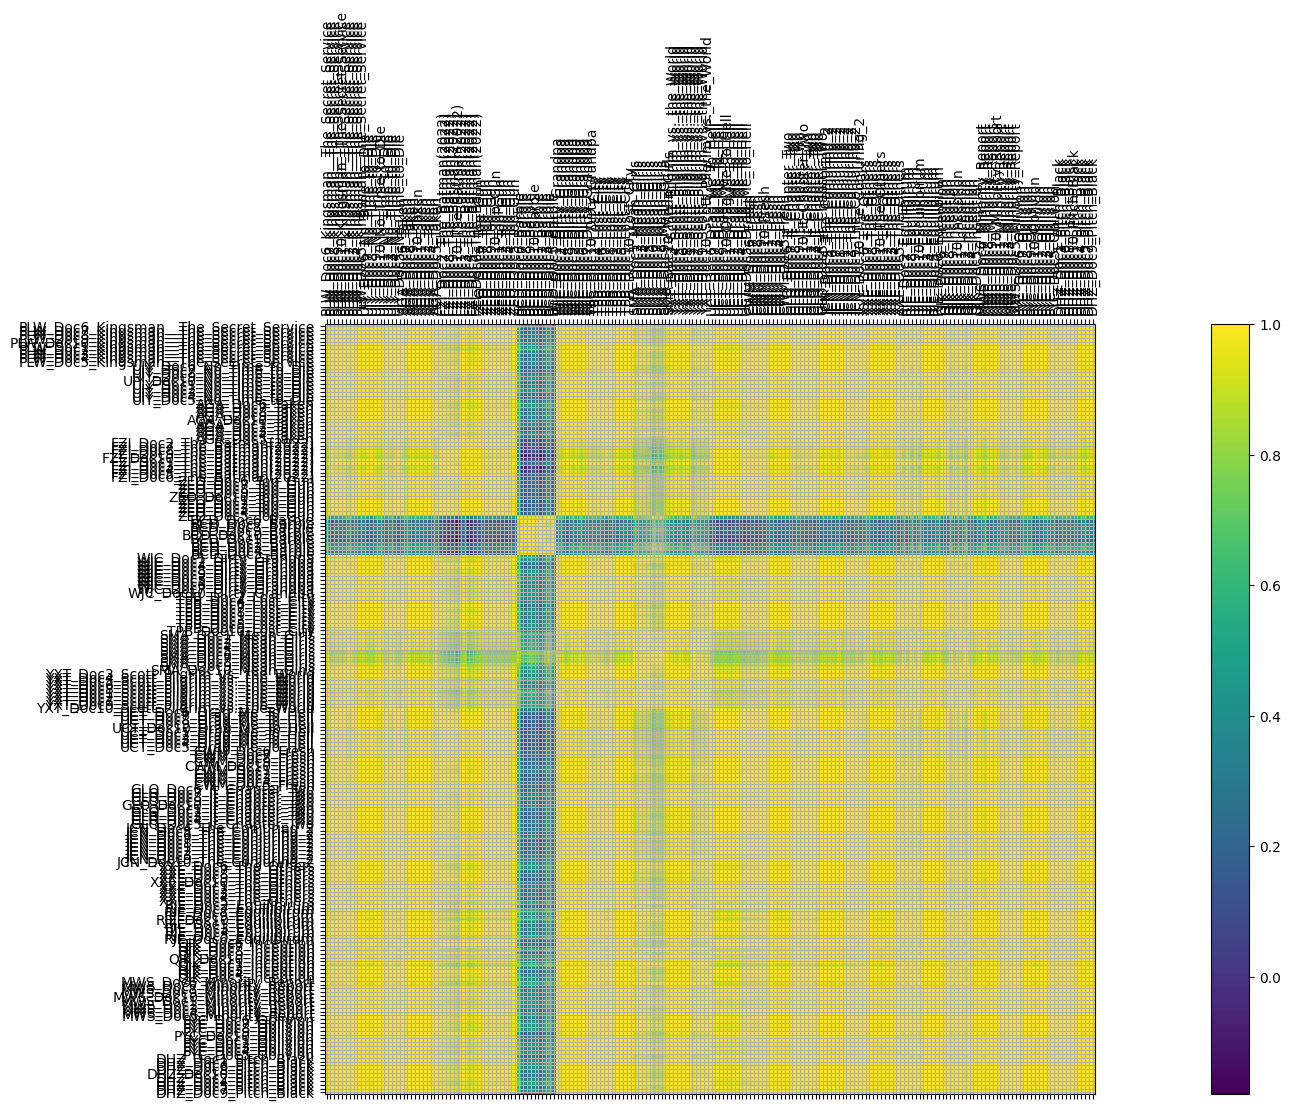

In [48]:

model_2concepts_10words = plot_lsa(number_of_topics=2, words=10, titles=titles)

### Plotting 6 concepts and 10 words

[(0, '0.531*"movie" + 0.149*"films" + 0.148*"movies" + 0.142*"character" + 0.139*"story" + 0.128*"characters" + 0.127*"horror" + 0.122*"action" + 0.120*"first" + 0.115*"barbie"'), (1, '0.806*"barbie" + 0.161*"world" + -0.144*"movie" + 0.140*"gerwig" + 0.132*"gosling" + 0.124*"robbie" + 0.120*"barbies" + 0.120*"margot" + -0.111*"batman" + 0.090*"girls"'), (2, '0.781*"batman" + 0.163*"wayne" + 0.155*"pattinson" + 0.146*"bruce" + 0.137*"reeves" + 0.127*"robert" + -0.104*"maverick" + -0.095*"action" + 0.086*"gotham" + 0.079*"barbie"'), (3, '0.435*"movie" + -0.249*"action" + 0.237*"horror" + -0.213*"maverick" + -0.168*"scott" + -0.154*"films" + -0.136*"world" + -0.126*"character" + 0.125*"scary" + -0.112*"feels"'), (4, '0.372*"movie" + 0.269*"maverick" + 0.144*"barbie" + -0.143*"girls" + 0.136*"feels" + -0.126*"first" + 0.122*"character" + -0.118*"years" + 0.114*"action" + 0.111*"mavericks"'), (5, '-0.484*"girls" + -0.329*"school" + 0.188*"horror" + -0.177*"plastics" + -0.152*"lohan" + -0.1

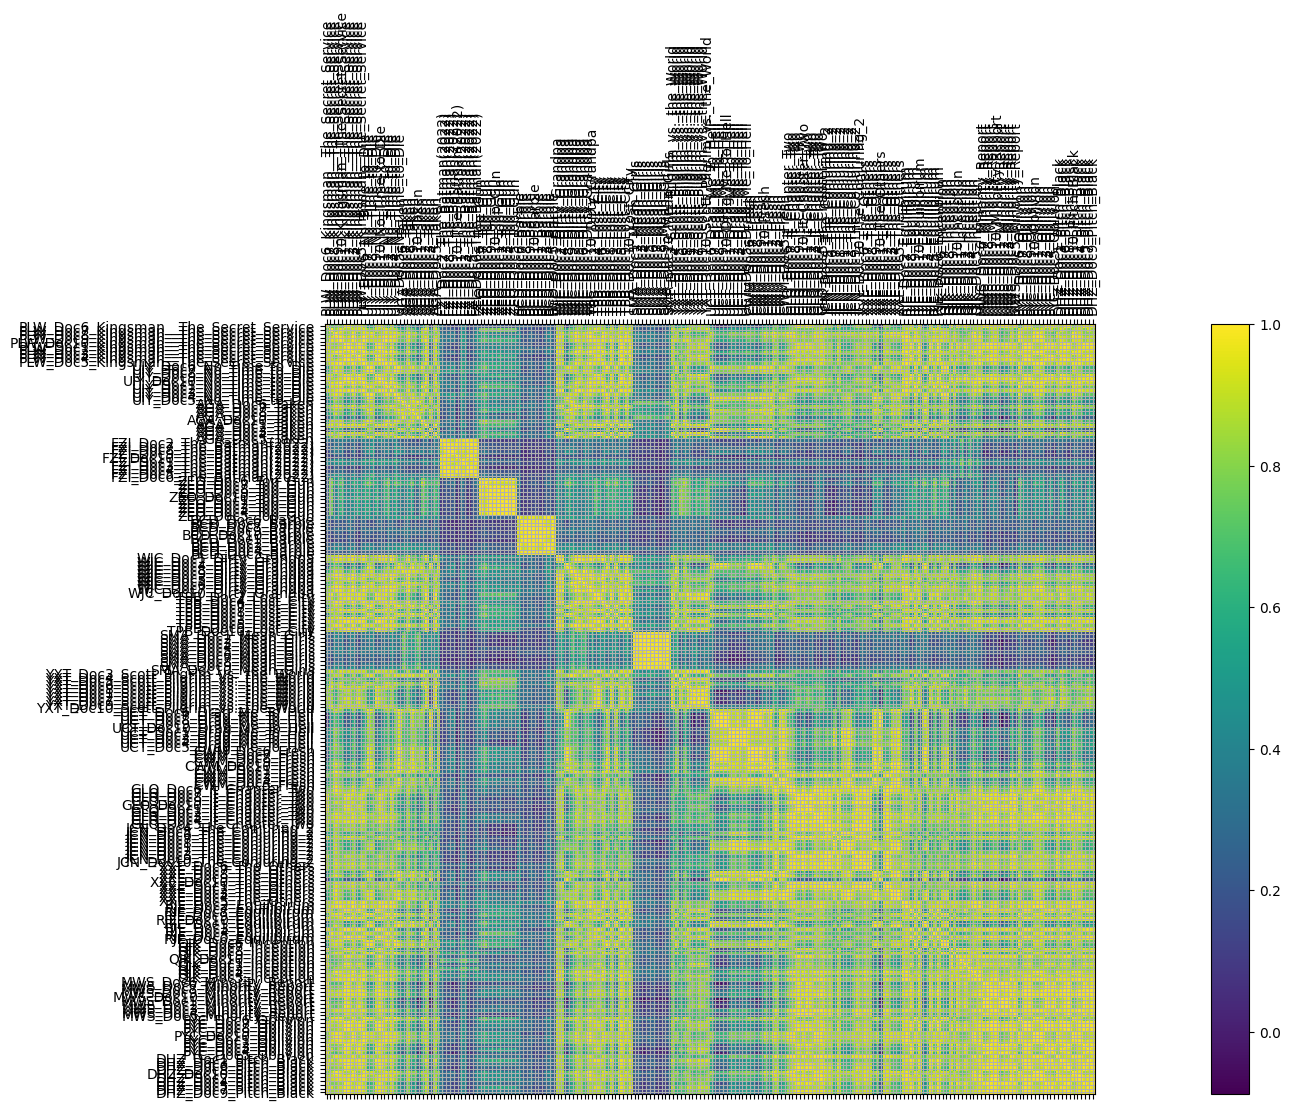

In [49]:
# model_6concepts_10words=plot_lsa(6, 10)

model_2concepts_10words = plot_lsa(number_of_topics=6, words=10, titles=titles)

### Plotting 20 concepts and 10 words

[(0, '-0.531*"movie" + -0.149*"films" + -0.148*"movies" + -0.142*"character" + -0.139*"story" + -0.128*"characters" + -0.127*"horror" + -0.122*"action" + -0.120*"first" + -0.115*"barbie"'), (1, '-0.806*"barbie" + -0.161*"world" + 0.144*"movie" + -0.140*"gerwig" + -0.132*"gosling" + -0.124*"robbie" + -0.120*"barbies" + -0.120*"margot" + 0.111*"batman" + -0.090*"girls"'), (2, '0.781*"batman" + 0.163*"wayne" + 0.155*"pattinson" + 0.146*"bruce" + 0.137*"reeves" + 0.127*"robert" + -0.104*"maverick" + -0.095*"action" + 0.086*"gotham" + 0.079*"barbie"'), (3, '-0.435*"movie" + 0.249*"action" + -0.237*"horror" + 0.213*"maverick" + 0.168*"scott" + 0.154*"films" + 0.136*"world" + 0.126*"character" + -0.125*"scary" + 0.112*"feels"'), (4, '-0.372*"movie" + -0.269*"maverick" + -0.144*"barbie" + 0.143*"girls" + -0.136*"feels" + 0.126*"first" + -0.122*"character" + 0.118*"years" + -0.114*"action" + -0.111*"mavericks"'), (5, '0.484*"girls" + 0.329*"school" + -0.188*"horror" + 0.177*"plastics" + 0.152*"

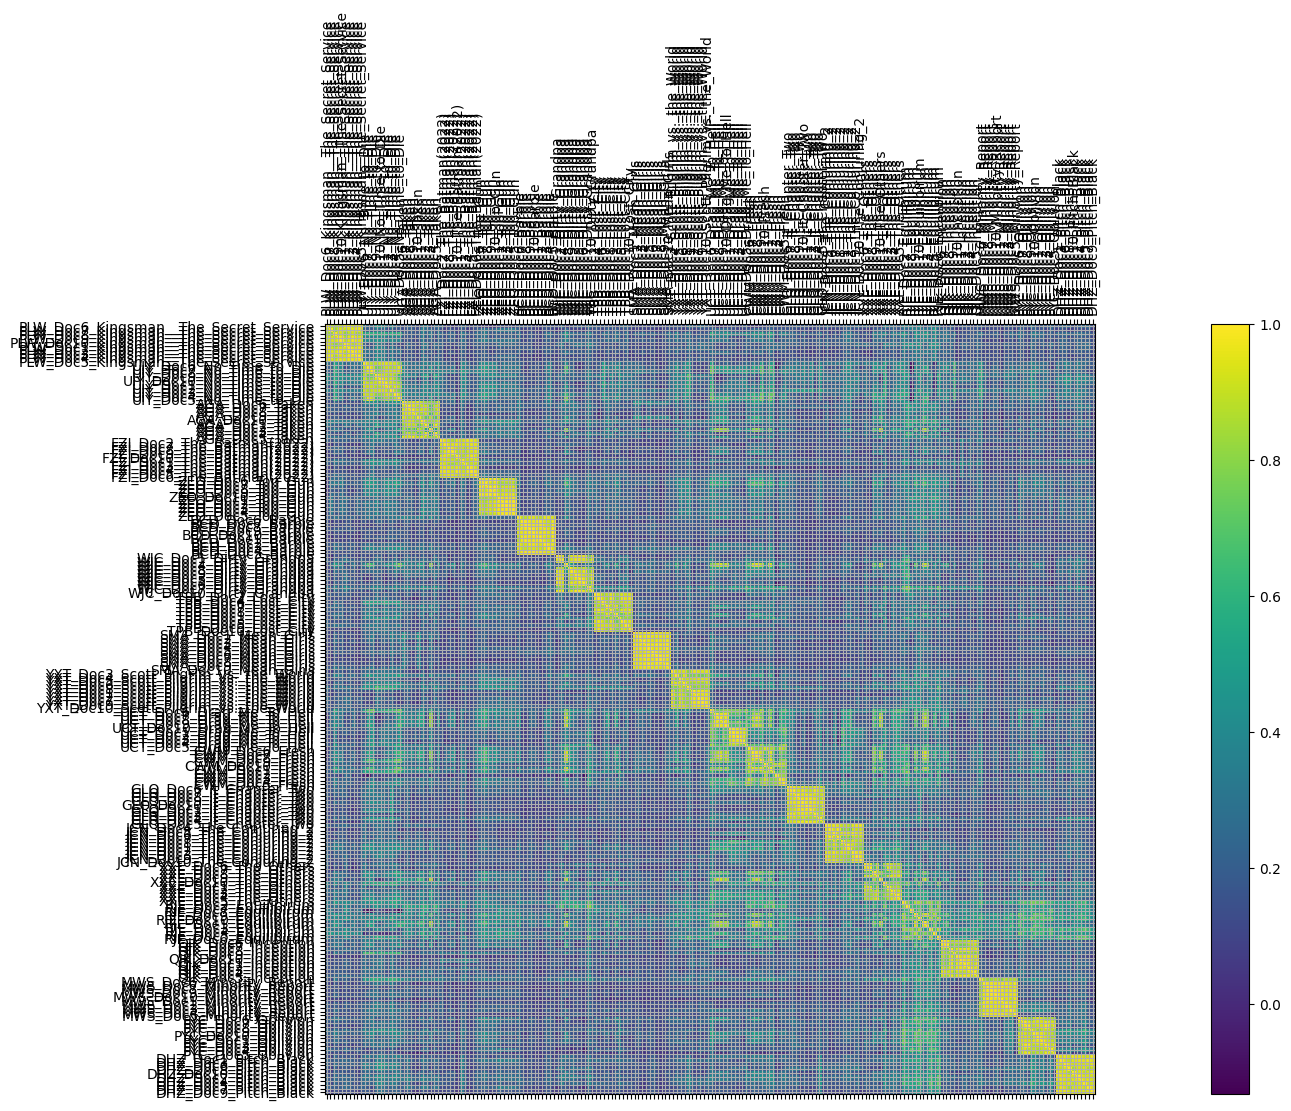

In [50]:
# model_20concepts_10words=plot_lsa(20, 10)

model_2concepts_10words = plot_lsa(number_of_topics=20, words=10, titles=titles)

### Compare LSA Model Coherence

In [51]:
topics = [6, 2, 10]
coherence_values = []
for t in topics:
    #BARRYC EXPERIMENTAL#1
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10, titles)
    # lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10)


    coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)


coherence ={'6 concepts 10 words':coherence_values[0],
           '2 concepts 10 words': coherence_values[1],
           '20 concepts 10 words':coherence_values[2]}

print(coherence)

[(0, '0.531*"movie" + 0.149*"films" + 0.148*"movies" + 0.142*"character" + 0.139*"story" + 0.128*"characters" + 0.127*"horror" + 0.122*"action" + 0.120*"first" + 0.115*"barbie"'), (1, '-0.806*"barbie" + -0.161*"world" + 0.144*"movie" + -0.140*"gerwig" + -0.132*"gosling" + -0.124*"robbie" + -0.120*"barbies" + -0.120*"margot" + 0.111*"batman" + -0.090*"girls"'), (2, '0.781*"batman" + 0.163*"wayne" + 0.155*"pattinson" + 0.146*"bruce" + 0.137*"reeves" + 0.127*"robert" + -0.104*"maverick" + -0.095*"action" + 0.086*"gotham" + 0.079*"barbie"'), (3, '0.435*"movie" + -0.249*"action" + 0.237*"horror" + -0.213*"maverick" + -0.168*"scott" + -0.154*"films" + -0.136*"world" + -0.126*"character" + 0.125*"scary" + -0.112*"feels"'), (4, '0.372*"movie" + 0.269*"maverick" + 0.144*"barbie" + -0.143*"girls" + 0.136*"feels" + -0.126*"first" + 0.122*"character" + -0.118*"years" + 0.114*"action" + 0.111*"mavericks"'), (5, '-0.484*"girls" + -0.329*"school" + 0.188*"horror" + -0.177*"plastics" + -0.152*"lohan" 

[(0, '0.531*"movie" + 0.149*"films" + 0.148*"movies" + 0.142*"character" + 0.139*"story" + 0.128*"characters" + 0.127*"horror" + 0.122*"action" + 0.120*"first" + 0.115*"barbie"'), (1, '0.806*"barbie" + 0.161*"world" + -0.144*"movie" + 0.140*"gerwig" + 0.132*"gosling" + 0.124*"robbie" + 0.120*"barbies" + 0.120*"margot" + -0.111*"batman" + 0.090*"girls"')]
Most similar titles for topic #0: ['PLW_Doc6_Kingsman__The_Secret_Service', 'SMA_Doc2_Mean_Girls', 'YXT_Doc7_Scott_Pilgrim_vs._the_World', 'RJE_Doc8_Equilibirum', 'YXT_Doc2_Scott_Pilgrim_vs._the_World']
Most similar titles for topic #1: ['PLW_Doc7_Kingsman__The_Secret_Service', 'FZI_Doc3_The_Batman(2022)', 'CWM_Doc7_Fresh', 'WJC_Doc4_Dirty_Grandpa', 'UIY_Doc7_No_Time_to_Die']
Titles for topic #0: ['PLW_Doc6_Kingsman__The_Secret_Service', 'SMA_Doc2_Mean_Girls', 'YXT_Doc7_Scott_Pilgrim_vs._the_World', 'RJE_Doc8_Equilibirum', 'YXT_Doc2_Scott_Pilgrim_vs._the_World', 'YXT_Doc5_Scott_Pilgrim_vs._the_World', 'YXT_Doc9_Scott_Pilgrim_vs._the_Wo

[(0, '-0.531*"movie" + -0.149*"films" + -0.148*"movies" + -0.142*"character" + -0.139*"story" + -0.128*"characters" + -0.127*"horror" + -0.122*"action" + -0.120*"first" + -0.115*"barbie"'), (1, '-0.806*"barbie" + -0.161*"world" + 0.144*"movie" + -0.140*"gerwig" + -0.132*"gosling" + -0.124*"robbie" + -0.120*"barbies" + -0.120*"margot" + 0.111*"batman" + -0.090*"girls"'), (2, '-0.781*"batman" + -0.163*"wayne" + -0.155*"pattinson" + -0.146*"bruce" + -0.137*"reeves" + -0.127*"robert" + 0.104*"maverick" + 0.095*"action" + -0.086*"gotham" + -0.079*"barbie"'), (3, '-0.435*"movie" + 0.249*"action" + -0.237*"horror" + 0.213*"maverick" + 0.168*"scott" + 0.154*"films" + 0.136*"world" + 0.126*"character" + -0.125*"scary" + 0.112*"feels"'), (4, '-0.372*"movie" + -0.269*"maverick" + -0.144*"barbie" + 0.143*"girls" + -0.136*"feels" + 0.126*"first" + -0.122*"character" + 0.118*"years" + -0.114*"action" + -0.111*"mavericks"'), (5, '0.484*"girls" + 0.329*"school" + -0.188*"horror" + 0.177*"plastics" + 0

## Latent Dirichlet Allocation - Research Number of Topics and Number of Words

In [52]:
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=4
words=20
#####################################

[(0, '0.009*"movie" + 0.004*"batman" + 0.004*"story" + 0.004*"first" + 0.003*"really" + 0.003*"horror" + 0.003*"films" + 0.003*"character" + 0.003*"characters" + 0.003*"movies" + 0.003*"years" + 0.002*"doesnt" + 0.002*"director" + 0.002*"something" + 0.002*"people" + 0.002*"world" + 0.002*"would" + 0.002*"could" + 0.002*"thats" + 0.002*"still"'), (1, '0.009*"movie" + 0.005*"movies" + 0.004*"horror" + 0.002*"people" + 0.002*"years" + 0.002*"eggsy" + 0.002*"kingsman" + 0.002*"batman" + 0.002*"films" + 0.002*"first" + 0.002*"action" + 0.002*"scenes" + 0.002*"makes" + 0.002*"vaughn" + 0.002*"really" + 0.001*"christine" + 0.001*"characters" + 0.001*"harry" + 0.001*"nothing" + 0.001*"james"'), (2, '0.009*"movie" + 0.005*"action" + 0.004*"films" + 0.004*"character" + 0.003*"maverick" + 0.003*"world" + 0.003*"characters" + 0.003*"feels" + 0.003*"thats" + 0.003*"girls" + 0.003*"first" + 0.002*"story" + 0.002*"scott" + 0.002*"school" + 0.002*"movies" + 0.002*"cruise" + 0.002*"would" + 0.002*"ano

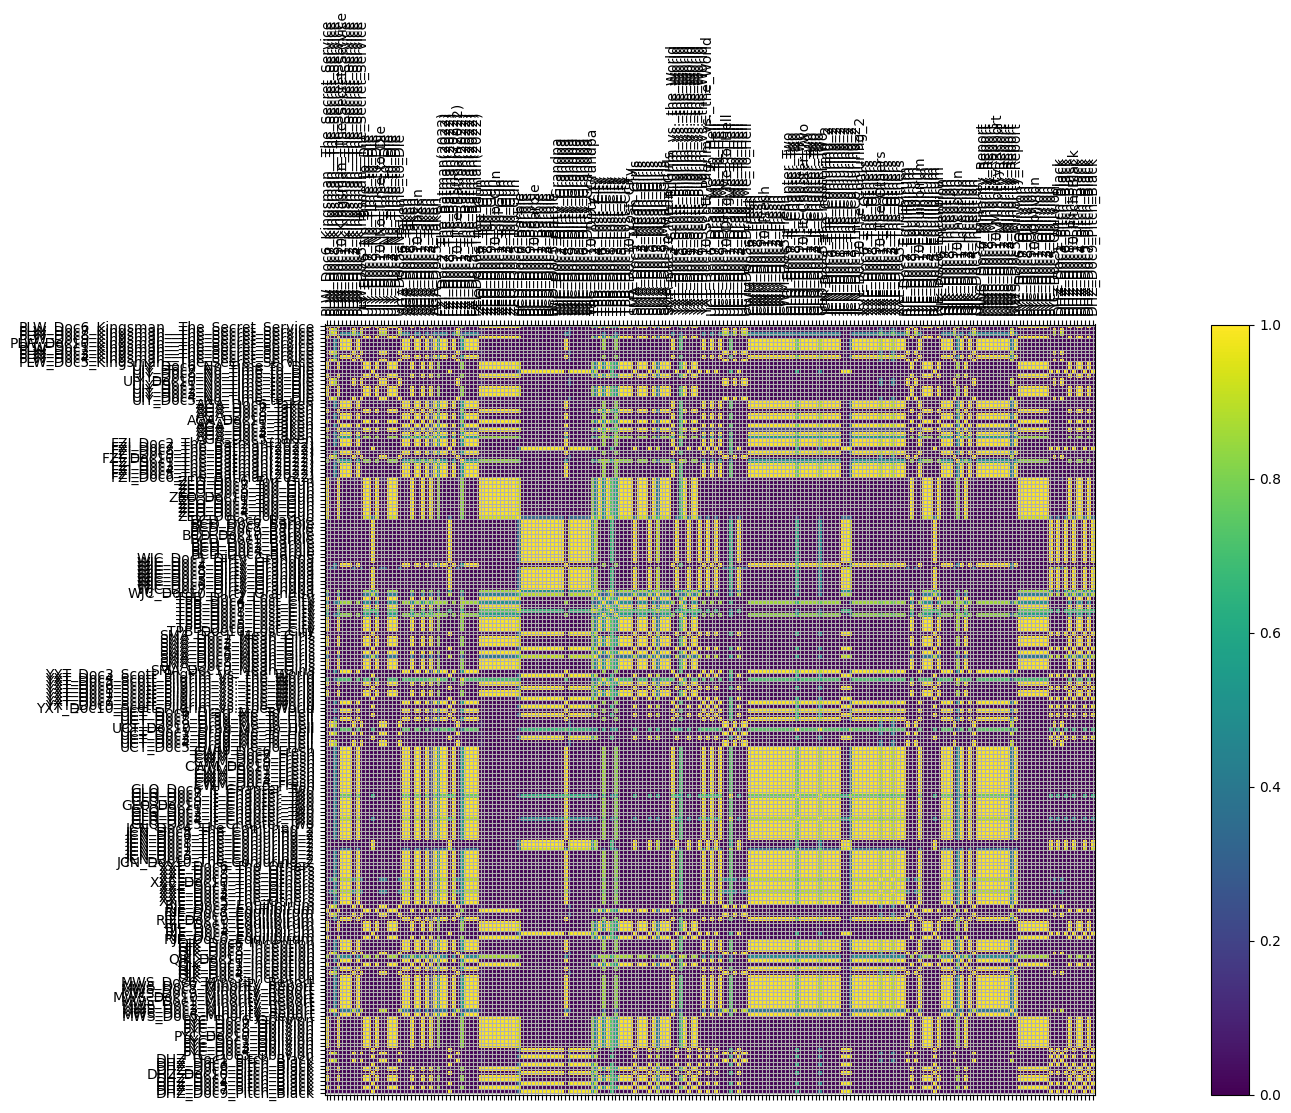

In [53]:
# BARRYC EXPERIMENTAL#1
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words,titles)
# model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

### Compare LDA Model Coherence

In [54]:
topics = [6, 2, 10]
coherence_values = []
for t in topics:
    #BARRYC EXPERIMENTAL#1
    ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10,titles)
    # ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10)


    coherence_model_lda = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)


coherence ={'6 topic 10 words':coherence_values[0],
           '2 topic 10 words': coherence_values[1],
           '20 topic 10 words':coherence_values[2]}

print(coherence)

[(0, '0.009*"movie" + 0.005*"story" + 0.004*"films" + 0.004*"batman" + 0.003*"first" + 0.003*"really" + 0.003*"people" + 0.003*"world" + 0.003*"doesnt" + 0.003*"horror"'), (1, '0.015*"movie" + 0.006*"movies" + 0.004*"horror" + 0.003*"people" + 0.003*"really" + 0.002*"thats" + 0.002*"batman" + 0.002*"eggsy" + 0.002*"scenes" + 0.002*"years"'), (2, '0.009*"movie" + 0.004*"action" + 0.003*"films" + 0.003*"world" + 0.003*"girls" + 0.003*"scott" + 0.003*"character" + 0.003*"thats" + 0.003*"first" + 0.003*"school"'), (3, '0.013*"barbie" + 0.007*"movie" + 0.005*"world" + 0.004*"girls" + 0.004*"characters" + 0.003*"films" + 0.003*"character" + 0.003*"jason" + 0.002*"black" + 0.002*"every"'), (4, '0.009*"movie" + 0.006*"horror" + 0.004*"feels" + 0.004*"batman" + 0.004*"films" + 0.003*"story" + 0.003*"character" + 0.003*"little" + 0.003*"action" + 0.003*"scenes"'), (5, '0.006*"pennywise" + 0.005*"chapter" + 0.005*"losers" + 0.005*"movie" + 0.004*"daughter" + 0.004*"paris" + 0.004*"first" + 0.004*

[(0, '0.009*"movie" + 0.003*"story" + 0.003*"films" + 0.003*"batman" + 0.003*"first" + 0.003*"horror" + 0.003*"really" + 0.003*"character" + 0.003*"world" + 0.003*"characters"'), (1, '0.008*"movie" + 0.003*"films" + 0.003*"movies" + 0.003*"action" + 0.003*"character" + 0.003*"world" + 0.002*"characters" + 0.002*"barbie" + 0.002*"first" + 0.002*"story"')]
Most similar titles for topic #0: ['PLW_Doc6_Kingsman__The_Secret_Service', 'PLW_Doc7_Kingsman__The_Secret_Service', 'PLW_Doc3_Kingsman__The_Secret_Service', 'PLW_Doc5_Kingsman__The_Secret_Service', 'UIY_Doc6_No_Time_to_Die']
Most similar titles for topic #1: ['PLW_Doc6_Kingsman__The_Secret_Service', 'PLW_Doc7_Kingsman__The_Secret_Service', 'PLW_Doc3_Kingsman__The_Secret_Service', 'PLW_Doc5_Kingsman__The_Secret_Service', 'UIY_Doc6_No_Time_to_Die']
Titles for topic #0: ['PLW_Doc6_Kingsman__The_Secret_Service', 'PLW_Doc7_Kingsman__The_Secret_Service', 'PLW_Doc3_Kingsman__The_Secret_Service', 'PLW_Doc5_Kingsman__The_Secret_Service', 'UIY_

[(0, '0.013*"movie" + 0.007*"batman" + 0.004*"fresh" + 0.004*"films" + 0.004*"horror" + 0.004*"story" + 0.004*"first" + 0.004*"inception" + 0.004*"character" + 0.004*"people"'), (1, '0.009*"movie" + 0.005*"movies" + 0.003*"earth" + 0.003*"years" + 0.003*"preston" + 0.002*"minutes" + 0.002*"would" + 0.002*"characters" + 0.002*"james" + 0.002*"story"'), (2, '0.009*"movie" + 0.007*"action" + 0.005*"maverick" + 0.005*"girls" + 0.005*"films" + 0.004*"school" + 0.004*"character" + 0.003*"characters" + 0.003*"scott" + 0.003*"world"'), (3, '0.008*"jason" + 0.005*"grandpa" + 0.005*"dirty" + 0.004*"films" + 0.004*"characters" + 0.004*"movie" + 0.004*"comedy" + 0.003*"efron" + 0.003*"things" + 0.003*"world"'), (4, '0.010*"movie" + 0.005*"feels" + 0.005*"horror" + 0.004*"character" + 0.004*"anderton" + 0.004*"story" + 0.004*"conjuring" + 0.003*"characters" + 0.003*"another" + 0.003*"precrime"'), (5, '0.006*"daughter" + 0.006*"movie" + 0.006*"paris" + 0.004*"batman" + 0.004*"girls" + 0.003*"first" 

# **BERTopic**

This section of the code demonstrates the BERTopic library to extract topics and visualize the distribution and relationships between them.

You've already done preprocessing earlier by cleaning the text by removing punctuation, filtering out stop words and short tokens, and converting text to lowercase. You could also try with the raw sentences too!

Then there is topic modeling with BERTopic to identify and analyze underlying themes in the dataset.

&nbsp;

In [55]:
    pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.2 MB/s eta 0:00:00


In [56]:
# pip install --upgrade openai

In [57]:
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt

import pandas as pd
import os
import numpy as np
from bertopic import BERTopic
import warnings
warnings.filterwarnings('ignore')

In [58]:
# ALREADY DONE EARLIER

# import nltk
# nltk.download('stopwords')

#functions used to process text and create the required TFIDF and Doc2vec Matrices
# def clean_doc(doc):
#     ...

# def final_processed_text(doc):
#     #this is a function to join the processed text back
#     ...

In [59]:
# ALREADY DONE EARLIER

# #read in class corpus csv into python
# data=pd.read_csv(r'MSDS453_QA_20220906.csv')

# #adding two columns to the dataframe to store the processed text and tokenized text
# data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

# #creating final processed text variables for matrix creation
# final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
# titles = data['Movie Title'].tolist()
# processed_text = data['processed_text'].tolist()

In [60]:
len(final_processed_text)

200

In [61]:
final_processed_text[1]

'reason kingsman secret service leaves feeling rooked wastes onceinanactorslifetime opportunity casting colin firth lethal gentleman superspy stranding without elegant derringdo catching lightning bottle opening stopper letting flash firth plays harry galahad member independent british secret service patterns arthurs round table michael caine plays chief arthur firth focused primed action passes master movie strategy audiences meant smile seeing beloved humanist pubfull thugs addled fundamentalists audiences movie rrated identify galahads protege eggsy unwin taron egerton bright strong goodhearted north london housing project eggsy kingsman agent handful comrades including harry agent takes cause hoping honor prove agency reinvigorate proletarian blood films scattered semifunny riffs harry eggsy whether knows trading places femme nikita pretty woman answer nobut eggsy preferred firths hyperrational magician played henry higgins stones psychic eliza doolittle magic moonlight kingsman wr

In [62]:
from bertopic import BERTopic
topic_model = BERTopic(min_topic_size=2)

In [63]:
topics, probs = topic_model.fit_transform(final_processed_text)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [64]:
topic_model.get_topic_info()

Topic  Count                                   Name  \
0      -1      5      -1_lifetime_movie_horror_children   
1       0     11   0_conjuring_lorraine_warrens_enfield   
2       1     10          1_kingsman_eggsy_firth_secret   
3       2     10          2_scott_pilgrim_ramona_wright   
4       3     10         3_oblivion_earth_drones_cruise   
5       4     10    4_anderton_minority_report_precrime   
6       5     10         5_inception_dreams_nolan_dream   
7       6     10  6_preston_equilibrium_emotions_matrix   
8       7     10       7_pennywise_chapter_losers_derry   
9       8     10          8_craig_craigs_spectre_casino   
10      9     10             9_pitch_black_alien_planet   
11     10     10         10_girls_school_plastics_lohan   
12     11     10       11_bullock_loretta_tatum_romance   
13     12     10        12_barbie_gerwig_robbie_barbies   
14     13     10     13_maverick_feels_action_mavericks   
15     14     10       14_batman_reeves_pattinson_wayne   
16     15     10         15_daughter_paris_neeson_taken   
17     16      9           16_jason_grandpa_dirty_efron   
18     17      9        17_horror_christine_raimi_movie   
19     18      6         18_grace_others_house_amenabar   
20     19      5    19_fresh_sebastian_daisy_edgarjones   
21     20      3            20_movie_really_maybe_wasnt   
22     21      2        21_fresh_edgarjones_maybe_wasnt   

                                       Representation  \
0   [lifetime, movie, horror, children, people, ac...   
1   [conjuring, lorraine, warrens, enfield, amityv...   
2   [kingsman, eggsy, firth, secret, vaughn, servi...   
3   [scott, pilgrim, ramona, wright, scotts, micha...   
4   [oblivion, earth, drones, cruise, victoria, sc...   
5   [anderton, minority, report, precrime, spielbe...   
6   [inception, dreams, nolan, dream, nolans, chri...   
7   [preston, equilibrium, emotions, matrix, emoti...   
8   [pennywise, chapter, losers, derry, muschietti...   
9   [craig, craigs, spectre, casino, franchise, ro...   
10  [pitch, black, alien, planet, crash, eclipse, ...   
11  [girls, school, plastics, lohan, queen, regina...   
12  [bullock, loretta, tatum, romance, sandra, rad...   
13  [barbie, gerwig, robbie, barbies, gosling, mar...   
14  [maverick, feels, action, mavericks, aerial, e...   
15  [batman, reeves, pattinson, wayne, bruce, goth...   
16  [daughter, paris, neeson, taken, bryan, kidnap...   
17  [jason, grandpa, dirty, efron, comedy, grandfa...   
18  [horror, christine, raimi, movie, lohman, scar...   
19  [grace, others, house, amenabar, kidman, child...   
20  [fresh, sebastian, daisy, edgarjones, dating, ...   
21  [movie, really, maybe, wasnt, people, funny, a...   
22  [fresh, edgarjones, maybe, wasnt, twisted, thr...   

                                  Representative_Docs  
0   [admit watching movie despite several friends ...  
1   [prologue conjuring effective sequence james m...  
2   [kingsman secret service starring natty colin ...  
3   [normally opinions longer paragraph movies hou...  
4   [squirming cruise scifi vehicle oblivion flash...  
5   [steven spielbergs minority report realizes po...  
6   [dreams theyre infantile heaven knows artist l...  
7   [science fiction genre creating visions nightm...  
8   [stephen kings colossal course thousand pages ...  
9   [latest appearance daniel craig james movie mo...  
10  [making purely scifi action movie becoming cer...  
11  [refuse believe someone smarts would content s...  
12  [sandra bullock channing tatum revive romcomad...  
13  [packaging barbie tedious inside ingeniously y...  
14  [remembered iconic movie revisited today doesn...  
15  [batman fighting crime fighting sleep gonna pr...  
16  [takensometimes power press pause movie punter...  
17  [pinpoint exactly began comedy worse within de...  
18  [intense opening scene stellar shocking finale...  
19  [others suspenseful horror unlike concerned bl...  
20  [caves directional debut tries capture

In [65]:
topic_model.visualize_barchart()

In [66]:
topic_model.visualize_heatmap()

In [67]:
topic_model.get_document_info(final_processed_text)

Document  Topic  \
0    complaint always dogged james franchise years ...      1   
1    reason kingsman secret service leaves feeling ...      1   
2    kingsman secret service makes rules along take...      1   
3    silly sadistic finally little galling kingsman...      1   
4    amused james abdicated title thats millardave ...      1   
..                                                 ...    ...   
195  genre pitch black rattletrap spook alien thats...      9   
196  sometimes movie value casablanca shocking soun...      9   
197  pitch black another alien formula group people...      9   
198  making purely scifi action movie becoming cert...      9   
199  diesel suddenly largely unknown actor whose si...      9   

                              Name  \
0    1_kingsman_eggsy_firth_secret   
1    1_kingsman_eggsy_firth_secret   
2    1_kingsman_eggsy_firth_secret   
3    1_kingsman_eggsy_firth_secret   
4    1_kingsman_eggsy_firth_secret   
..                             ...   
195     9_pitch_black_alien_planet   
196     9_pitch_black_alien_planet   
197     9_pitch_black_alien_planet   
198     9_pitch_black_alien_planet   
199     9_pitch_black_alien_planet   

                                        Representation  \
0    [kingsman, eggsy, firth, secret, vaughn, servi...   
1    [kingsman, eggsy, firth, secret, vaughn, servi...   
2    [kingsman, eggsy, firth, secret, vaughn, servi...   
3    [kingsman, eggsy, firth, secret, vaughn, servi...   
4    [kingsman, eggsy, firth, secret, vaughn, servi...   
..                                                 ...   
195  [pitch, black, alien, planet, crash, eclipse, ...   
196  [pitch, black, alien, planet, crash, eclipse, ...   
197  [pitch, black, alien, planet, crash, eclipse, ...   
198  [pitch, black, alien, planet, crash, eclipse, ...   
199  [pitch, black, alien, planet, crash, eclipse, ...   

                                   Representative_Docs  \
0    [kingsman secret service starring natty colin ...   
1    [kingsman secret service starring natty colin ...   
2    [kingsman secret service starring natty colin ...   
3    [kingsman secret service starring natty colin ...   
4    [kingsman secret service starring natty colin ...   
..                                                 ...   
195  [making purely scifi action movie becoming cer...   
196  [making purely scifi action movie becoming cer...   
197  [making purely scifi action movie becoming cer...   
198  [making purely scifi action movie becoming cer...   
199  [making purely scifi action movie becoming cer...   

                                           Top_n_words  Probability  \
0    kingsman - eggsy - firth - secret - vaughn - s...     0.591748   
1    kingsman - eggsy - firth - secret - vaughn - s...     1.000000   
2    kingsman - eggsy - firth - secret - vaughn - s...     1.000000   
3    kingsman - eggsy - firth - secret - vaughn - s...     1.000000   
4    kingsman - eggsy - firth - secret - vaughn - s...     1.000000   
..                                                 ...          ...   
195  pitch - black - alien - planet - crash - eclip...     0.514444   
196  pitch - black - alien - planet - crash - eclip...     0.327336   
197  pitch - black - alien - planet - crash - eclip...     0.716479   
198  pitch - black - alien - planet - crash - eclip...     1.000000   
199  pitch - black - alien - planet - crash - eclip...     0.641681   

     Representative_document  
0                      False  
1                       True  
2                      False  
3                      False  
4                      False  
..                       ...  
195                    False  
196                    False  
197                    False  
198                     True  
199                     True  

[200 rows x 8 columns]

# **6. Cluster Model Research: KMeans, SVM, Logistic, Naive Bayes, Randomforest, BERT**


## NLP Supervised and Unsupervised Learning Methods:
1. K-Means Clustering (Unsupervised)
2. Support Vector Machines (SVMs) (Supervised)
3. (Multinomial) Naïve Bayes (MultinomialNB) (Supervised)
4. Logistic Regression (Supervised)

### Generate TF-IDF For Analysis

In [68]:
tfidf_matrix = tfidf(final_processed_text, titles, ngram_range = (1,1))

### KMeans Clustering

<div class="alert alert-block alert-success">
    <b>sklearn.cluster.KMeans</b>:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html<br><br>
<b>KMeans Default Parameters</b>:<br>
    class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
    </div>

In [69]:
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k=4)

cluster_title {0: ['ZEO_Doc6_Top_Gun', 'ZEO_Doc7_Top_Gun', 'ZEO_Doc8_Top_Gun', 'ZEO_Doc9_Top_Gun', 'ZEO_Doc10_Top_Gun', 'ZEO_Doc1_Top_Gun', 'ZEO_Doc2_Top_Gun', 'ZEO_Doc3_Top_Gun', 'ZEO_Doc4_Top_Gun', 'ZEO_Doc5_Top_Gun', 'YXT_Doc3_Scott_Pilgrim_vs._the_World', 'YXT_Doc4_Scott_Pilgrim_vs._the_World', 'YXT_Doc5_Scott_Pilgrim_vs._the_World', 'YXT_Doc6_Scott_Pilgrim_vs._the_World', 'YXT_Doc8_Scott_Pilgrim_vs._the_World', 'YXT_Doc1_Scott_Pilgrim_vs._the_World', 'YXT_Doc2_Scott_Pilgrim_vs._the_World', 'YXT_Doc7_Scott_Pilgrim_vs._the_World', 'YXT_Doc9_Scott_Pilgrim_vs._the_World', 'YXT_Doc10_Scott_Pilgrim_vs._the_World', 'RJE_Doc8_Equilibirum', 'RJE_Doc10_Equilibirum', 'RJE_Doc5_Equilibirum', 'MWS_Doc7_Minority_Report', 'MWS_Doc8_Minority_Report', 'MWS_Doc9_Minority_Report', 'MWS_Doc10_Minority_Report', 'MWS_Doc1_Minority_Report', 'MWS_Doc2_Minority_Report', 'MWS_Doc5_Minority_Report', 'PYC_Doc1_Oblivion', 'PYC_Doc3_Oblivion', 'PYC_Doc4_Oblivion'], 1: ['BCD_Doc6_Barbie', 'BCD_Doc7_Barbie', 'BC

### Access Each Cluster - Changing Dictionary KeyValue from 0 to k

In [70]:
cluster_title[2]

['AGA_Doc7_Taken',
 'AGA_Doc9_Taken',
 'AGA_Doc10_Taken',
 'AGA_Doc1_Taken',
 'AGA_Doc2_Taken',
 'FZI_Doc7_The_Batman(2022)',
 'FZI_Doc9_The_Batman(2022)',
 'FZI_Doc3_The_Batman(2022)',
 'FZI_Doc6_The_Batman(2022)',
 'WJC_Doc1_Dirty_Grandpa',
 'WJC_Doc2_Dirty_Grandpa',
 'WJC_Doc4_Dirty_Grandpa',
 'WJC_Doc8_Dirty_Grandpa',
 'WJC_Doc9_Dirty_Grandpa',
 'WJC_Doc3_Dirty_Grandpa',
 'WJC_Doc5_Dirty_Grandpa',
 'WJC_Doc6_Dirty_Grandpa',
 'WJC_Doc7_Dirty_Grandpa',
 'WJC_Doc10_Dirty_Grandpa',
 'TPB_Doc3_Lost_City',
 'SMA_Doc1_Mean_Girls',
 'SMA_Doc2_Mean_Girls',
 'SMA_Doc3_Mean_Girls',
 'SMA_Doc4_Mean_Girls',
 'SMA_Doc5_Mean_Girls',
 'SMA_Doc6_Mean_Girls',
 'SMA_Doc7_Mean_Girls',
 'SMA_Doc8_Mean_Girls',
 'SMA_Doc9_Mean_Girls',
 'SMA_Doc10_Mean_Girls',
 'UCT_Doc6_Drag_Me_To_Hell',
 'UCT_Doc7_Drag_Me_To_Hell',
 'UCT_Doc8_Drag_Me_To_Hell',
 'UCT_Doc9_Drag_Me_To_Hell',
 'UCT_Doc10_Drag_Me_To_Hell',
 'UCT_Doc1_Drag_Me_To_Hell',
 'UCT_Doc2_Drag_Me_To_Hell',
 'UCT_Doc3_Drag_Me_To_Hell',
 'UCT_Doc4_Drag_

In [71]:
plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

In [72]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

def evaluate_k_means(titles, tfidf_matrix, k_range):
    best_k = None
    best_silhouette = -1  # Initialize with the lowest possible Silhouette Score
    best_inertia = float('inf')  # Initialize with the highest possible Inertia
    best_ch_score = -1  # Initialize with the lowest possible Calinski-Harabasz score

    results = []  # Store the results for each k

    # Loop through each value of k
    for k in k_range:
        print(f"Evaluating k={k}...")
        # Fit KMeans model
        km = KMeans(n_clusters=k, random_state=89)
        km.fit(tfidf_matrix)
        clusters = km.labels_.tolist()

        # Convert tfidf_matrix to dense if necessary
        dense_matrix = tfidf_matrix.toarray() if hasattr(tfidf_matrix, 'toarray') else tfidf_matrix

        # Calculate Silhouette Score
        silhouette_avg = silhouette_score(dense_matrix, clusters)

        # Calculate Inertia (Sum of Squared Distances)
        inertia = km.inertia_

        # Calculate Calinski-Harabasz Score
        ch_score = calinski_harabasz_score(dense_matrix, clusters)

        # Store the results
        results.append({'k': k, 'silhouette': silhouette_avg, 'inertia': inertia, 'ch_score': ch_score})
        print(f"k={k}, Silhouette: {silhouette_avg}, Inertia: {inertia}, Calinski-Harabasz: {ch_score}")

        # Check if this is the best k based on Silhouette Score
        if silhouette_avg > best_silhouette:
            best_k = k
            best_silhouette = silhouette_avg
            best_inertia = inertia
            best_ch_score = ch_score

    # Return the best k and its scores, as well as all results for comparison
    return best_k, best_silhouette, best_inertia, best_ch_score, results

# Define the range of k values to try
k_range = range(2, 20)  # Example: try k values from 2 to 9

# Call the function to evaluate k-means clustering for different k values
best_k, best_silhouette, best_inertia, best_ch_score, results = evaluate_k_means(titles, tfidf_matrix, k_range)

print(f"\nBest k: {best_k} with Silhouette Score: {best_silhouette}, Inertia: {best_inertia}, Calinski-Harabasz: {best_ch_score}")



Evaluating k=2...
k=2, Silhouette: 0.004975698708520934, Inertia: 189.73963321301582, Calinski-Harabasz: 1.9485655138216305
Evaluating k=3...
k=3, Silhouette: 0.0177312085066092, Inertia: 185.08152398498262, Calinski-Harabasz: 3.472794914550106
Evaluating k=4...
k=4, Silhouette: 0.01818667458942387, Inertia: 183.0621821615733, Calinski-Harabasz: 3.049539316217165
Evaluating k=5...
k=5, Silhouette: 0.020412549546243906, Inertia: 180.8881411035408, Calinski-Harabasz: 2.8887455455815614
Evaluating k=6...
k=6, Silhouette: 0.022552215473954827, Inertia: 178.80973726701734, Calinski-Harabasz: 2.7768631220034963
Evaluating k=7...
k=7, Silhouette: 0.02707881333586629, Inertia: 176.25722073147602, Calinski-Harabasz: 2.8012936020592836
Evaluating k=8...
k=8, Silhouette: 0.03420299476417037, Inertia: 172.81569079139604, Calinski-Harabasz: 2.9824618311489193
Evaluating k=9...
k=9, Silhouette: 0.03405778724501999, Inertia: 171.0917987869699, Calinski-Harabasz: 2.862780095397378
Evaluating k=10...
k

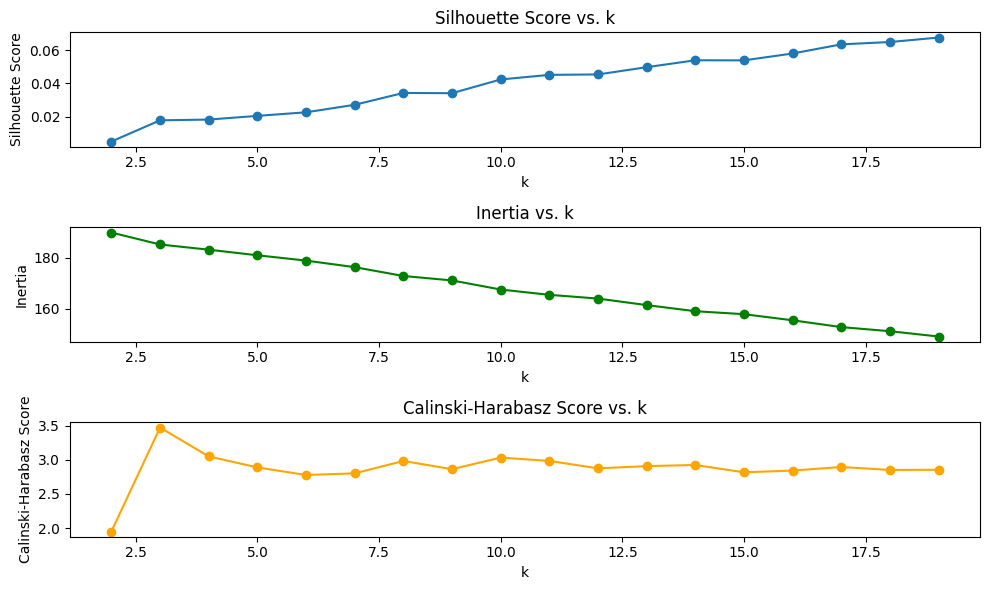

In [73]:
import matplotlib.pyplot as plt

def plot_k_means_results(results):
    # Extract values from the results list
    k_values = [result['k'] for result in results]
    silhouette_scores = [result['silhouette'] for result in results]
    inertia_scores = [result['inertia'] for result in results]
    ch_scores = [result['ch_score'] for result in results]

    # Plot Silhouette Score
    plt.figure(figsize=(10, 6))

    plt.subplot(3, 1, 1)  # 3 rows, 1 column, 1st plot
    plt.plot(k_values, silhouette_scores, marker='o')
    plt.title('Silhouette Score vs. k')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')

    # Plot Inertia
    plt.subplot(3, 1, 2)  # 3 rows, 1 column, 2nd plot
    plt.plot(k_values, inertia_scores, marker='o', color='green')
    plt.title('Inertia vs. k')
    plt.xlabel('k')
    plt.ylabel('Inertia')

    # Plot Calinski-Harabasz Score
    plt.subplot(3, 1, 3)  # 3 rows, 1 column, 3rd plot
    plt.plot(k_values, ch_scores, marker='o', color='orange')
    plt.title('Calinski-Harabasz Score vs. k')
    plt.xlabel('k')
    plt.ylabel('Calinski-Harabasz Score')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Call the function to plot the results
plot_k_means_results(results)

Evaluating k=2...
k=2, Silhouette: 0.16639430820941925, Inertia: 0.13834692537784576, Calinski-Harabasz: 46.70199361678325
Evaluating k=3...
k=3, Silhouette: 0.12434836477041245, Inertia: 0.1264154613018036, Calinski-Harabasz: 34.72249169155593
Evaluating k=4...
k=4, Silhouette: 0.11390712112188339, Inertia: 0.11811594665050507, Calinski-Harabasz: 29.239854065465355
Evaluating k=5...
k=5, Silhouette: 0.12819920480251312, Inertia: 0.1092979684472084, Calinski-Harabasz: 27.511263119826143
Evaluating k=6...
k=6, Silhouette: 0.12667541205883026, Inertia: 0.1029488816857338, Calinski-Harabasz: 25.63941065815988
Evaluating k=7...
k=7, Silhouette: 0.12198653072118759, Inertia: 0.09760843962430954, Calinski-Harabasz: 24.178958198800352
Evaluating k=8...
k=8, Silhouette: 0.09816554933786392, Inertia: 0.09668418765068054, Calinski-Harabasz: 21.076721272074142
Evaluating k=9...
k=9, Silhouette: 0.10550655424594879, Inertia: 0.09150204807519913, Calinski-Harabasz: 20.737221225397168
Evaluating k=1

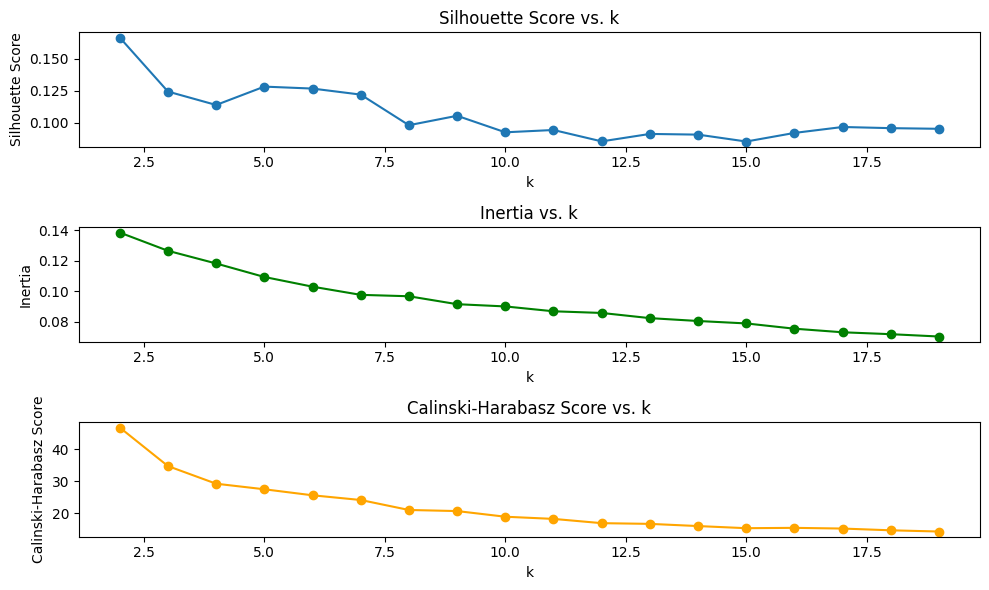


Best k based on Silhouette Score: 2
Silhouette Score: 0.16639430820941925, Inertia: 0.13834692537784576, Calinski-Harabasz Score: 46.70199361678325


In [74]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import numpy as np

# Train a Word2Vec model (using final_processed_text, which should be tokenized)
model = Word2Vec(sentences=final_processed_text, vector_size=100, window=5, min_count=1, workers=4)

# Get document vectors by averaging the word vectors for each document
def document_vector(model, doc):
    return np.mean([model.wv[word] for word in doc if word in model.wv], axis=0)

doc_vectors = [document_vector(model, doc) for doc in final_processed_text]

# Now perform K-means clustering on Word2Vec vectors
k_range = range(2, 20)
best_k, best_silhouette, best_inertia, best_ch_score, results = evaluate_k_means(titles, np.array(doc_vectors), k_range)
plot_k_means_results(results)

# Find the best k based on Silhouette Score (or other metrics if preferred)
best_result = max(results, key=lambda x: x['silhouette'])  # Pick the highest silhouette score
# You can also use Inertia or Calinski-Harabasz if needed by changing the key=lambda
# e.g., key=lambda x: x['inertia'] for lowest inertia

print(f"\nBest k based on Silhouette Score: {best_result['k']}")
print(f"Silhouette Score: {best_result['silhouette']}, Inertia: {best_result['inertia']}, Calinski-Harabasz Score: {best_result['ch_score']}")

In [75]:
# Use the best k found from Word2Vec (k=2)
best_k = 2  # Or change to 2 if you want to use Word2Vec clusters

# Run K-means again with the best k value
cluster_title, clusters, k_means_df = k_means(titles, tfidf_matrix, k=best_k)



cluster_title {0: ['PLW_Doc7_Kingsman__The_Secret_Service', 'PLW_Doc9_Kingsman__The_Secret_Service', 'PLW_Doc10_Kingsman__The_Secret_Service', 'PLW_Doc1_Kingsman__The_Secret_Service', 'PLW_Doc2_Kingsman__The_Secret_Service', 'PLW_Doc4_Kingsman__The_Secret_Service', 'UIY_Doc8_No_Time_to_Die', 'UIY_Doc9_No_Time_to_Die', 'UIY_Doc1_No_Time_to_Die', 'UIY_Doc2_No_Time_to_Die', 'FZI_Doc2_The_Batman(2022)', 'FZI_Doc7_The_Batman(2022)', 'FZI_Doc8_The_Batman(2022)', 'FZI_Doc9_The_Batman(2022)', 'FZI_Doc10_The_Batman(2022)', 'FZI_Doc1_The_Batman(2022)', 'FZI_Doc3_The_Batman(2022)', 'FZI_Doc4_The_Batman(2022)', 'FZI_Doc5_The_Batman(2022)', 'FZI_Doc6_The_Batman(2022)', 'ZEO_Doc6_Top_Gun', 'ZEO_Doc7_Top_Gun', 'ZEO_Doc8_Top_Gun', 'ZEO_Doc9_Top_Gun', 'ZEO_Doc10_Top_Gun', 'ZEO_Doc1_Top_Gun', 'ZEO_Doc2_Top_Gun', 'ZEO_Doc3_Top_Gun', 'ZEO_Doc4_Top_Gun', 'ZEO_Doc5_Top_Gun', 'WJC_Doc1_Dirty_Grandpa', 'WJC_Doc2_Dirty_Grandpa', 'WJC_Doc8_Dirty_Grandpa', 'WJC_Doc3_Dirty_Grandpa', 'WJC_Doc6_Dirty_Grandpa', 'WJC

In [76]:
# Check the actual unique cluster numbers in the 'Cluster' column
print("Unique clusters:", k_means_df['Cluster'].unique())

# Iterate through each cluster number and print the document titles assigned to each cluster
for cluster_num in k_means_df['Cluster'].unique():
    print(f"Cluster {cluster_num}:")
    for doc in k_means_df[k_means_df['Cluster'] == cluster_num]['Doc Name']:
        print(f"\t{doc}")

Unique clusters: [1 0]
Cluster 1:
	PLW_Doc6_Kingsman__The_Secret_Service
	PLW_Doc8_Kingsman__The_Secret_Service
	PLW_Doc3_Kingsman__The_Secret_Service
	PLW_Doc5_Kingsman__The_Secret_Service
	UIY_Doc6_No_Time_to_Die
	UIY_Doc7_No_Time_to_Die
	UIY_Doc10_No_Time_to_Die
	UIY_Doc3_No_Time_to_Die
	UIY_Doc4_No_Time_to_Die
	UIY_Doc5_No_Time_to_Die
	AGA_Doc6_Taken
	AGA_Doc7_Taken
	AGA_Doc8_Taken
	AGA_Doc9_Taken
	AGA_Doc10_Taken
	AGA_Doc1_Taken
	AGA_Doc2_Taken
	AGA_Doc3_Taken
	AGA_Doc4_Taken
	AGA_Doc5_Taken
	BCD_Doc6_Barbie
	BCD_Doc7_Barbie
	BCD_Doc8_Barbie
	BCD_Doc9_Barbie
	BCD_Doc10_Barbie
	BCD_Doc1_Barbie
	BCD_Doc2_Barbie
	BCD_Doc3_Barbie
	BCD_Doc4_Barbie
	BCD_Doc5_Barbie
	WJC_Doc4_Dirty_Grandpa
	WJC_Doc9_Dirty_Grandpa
	WJC_Doc5_Dirty_Grandpa
	WJC_Doc7_Dirty_Grandpa
	TPB_Doc6_Lost_City
	TPB_Doc10_Lost_City
	SMA_Doc1_Mean_Girls
	SMA_Doc2_Mean_Girls
	SMA_Doc5_Mean_Girls
	SMA_Doc6_Mean_Girls
	UCT_Doc6_Drag_Me_To_Hell
	CWM_Doc8_Fresh
	CWM_Doc1_Fresh
	GLQ_Doc6_It_Chapter_Two
	GLQ_Doc7_It_Chapter_Tw

In [77]:
# Perform k-means clustering with k=2
cluster_title, clusters, k_means_df = k_means(titles, tfidf_matrix, k=2)


cluster_title {0: ['PLW_Doc7_Kingsman__The_Secret_Service', 'PLW_Doc9_Kingsman__The_Secret_Service', 'PLW_Doc10_Kingsman__The_Secret_Service', 'PLW_Doc1_Kingsman__The_Secret_Service', 'PLW_Doc2_Kingsman__The_Secret_Service', 'PLW_Doc4_Kingsman__The_Secret_Service', 'UIY_Doc8_No_Time_to_Die', 'UIY_Doc9_No_Time_to_Die', 'UIY_Doc1_No_Time_to_Die', 'UIY_Doc2_No_Time_to_Die', 'FZI_Doc2_The_Batman(2022)', 'FZI_Doc7_The_Batman(2022)', 'FZI_Doc8_The_Batman(2022)', 'FZI_Doc9_The_Batman(2022)', 'FZI_Doc10_The_Batman(2022)', 'FZI_Doc1_The_Batman(2022)', 'FZI_Doc3_The_Batman(2022)', 'FZI_Doc4_The_Batman(2022)', 'FZI_Doc5_The_Batman(2022)', 'FZI_Doc6_The_Batman(2022)', 'ZEO_Doc6_Top_Gun', 'ZEO_Doc7_Top_Gun', 'ZEO_Doc8_Top_Gun', 'ZEO_Doc9_Top_Gun', 'ZEO_Doc10_Top_Gun', 'ZEO_Doc1_Top_Gun', 'ZEO_Doc2_Top_Gun', 'ZEO_Doc3_Top_Gun', 'ZEO_Doc4_Top_Gun', 'ZEO_Doc5_Top_Gun', 'WJC_Doc1_Dirty_Grandpa', 'WJC_Doc2_Dirty_Grandpa', 'WJC_Doc8_Dirty_Grandpa', 'WJC_Doc3_Dirty_Grandpa', 'WJC_Doc6_Dirty_Grandpa', 'WJC

In [78]:
import random
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def plot_tfidf_matrix(cluster_title, clusters, tfidf_matrix):
    # Convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    dist = 1 - cosine_similarity(tfidf_matrix)  # Distance matrix
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]

    # Set up cluster names using a dict
    cluster_dict = cluster_title

    # Create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0, len(clusters))))

    # Group by cluster
    groups = df.groupby('label')

    # Plot the clusters using matplotlib
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust size if needed
    ax.margins(0.05)  # Optional, just adds 5% padding to the autoscaling

    # Iterate through groups to layer the plot
    for name, group in groups:
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)  # Random RGB color for each cluster

        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_dict.get(name, f"Cluster {name}"), color=color, mec='none')

        ax.set_aspect('auto')
        ax.tick_params(
            axis='x',  # Changes apply to the x-axis
            which='both',  # Both major and minor ticks are affected
            bottom=False,  # Ticks along the bottom edge are off
            labelbottom=True)

        ax.tick_params(
            axis='y',  # Changes apply to the y-axis
            which='both',  # Both major and minor ticks are affected
            left=False,  # Ticks along the left edge are off
            labelleft=True)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 10})  # Show legend
    plt.show()

    # Print clusters and their coordinates (optional)
    for name, group in groups:
        print(f"Cluster {name} (Color: {color}):")
        for i, row in group.iterrows():
            print(f"Document {row['title']} at coordinates x: {row['x']:.3f}, y: {row['y']:.3f}")
        print("\n")  # Empty line between clusters

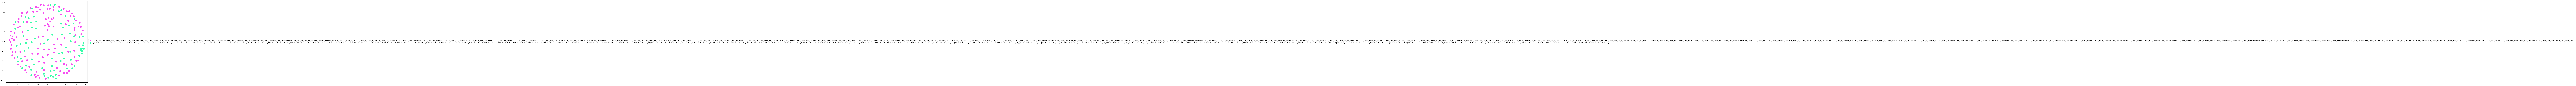

Cluster 0 (Color: (0.21154272021137543, 0.9913061626834407, 0.6607054621036492)):
Document 1.0 at coordinates x: 0.595, y: 0.427
Document 3.0 at coordinates x: -0.227, y: 0.707
Document 4.0 at coordinates x: -0.141, y: 0.649
Document 5.0 at coordinates x: 0.190, y: -0.415
Document 6.0 at coordinates x: -0.410, y: 0.400
Document 8.0 at coordinates x: -0.178, y: 0.693
Document 12.0 at coordinates x: -0.741, y: -0.151
Document 13.0 at coordinates x: -0.525, y: 0.518
Document 15.0 at coordinates x: -0.686, y: 0.347
Document 16.0 at coordinates x: -0.400, y: 0.604
Document 30.0 at coordinates x: -0.742, y: 0.203
Document 31.0 at coordinates x: -0.708, y: 0.099
Document 32.0 at coordinates x: -0.773, y: 0.026
Document 33.0 at coordinates x: -0.679, y: 0.031
Document 34.0 at coordinates x: -0.750, y: 0.120
Document 35.0 at coordinates x: -0.669, y: 0.171
Document 36.0 at coordinates x: -0.732, y: -0.077
Document 37.0 at coordinates x: -0.751, y: -0.015
Document 38.0 at coordinates x: -0.721, 

In [79]:
# Example usage for k=2 clusters (replace with the correct values for your case)
plot_tfidf_matrix(cluster_title, clusters, tfidf_matrix)

In [80]:
# Find the index of the document you are looking for
doc_name = "PLW_Doc6_Kingsman__The_Secret_Service"
doc_index = titles.index(doc_name)
print(f"Document {doc_name} is at index {doc_index}")

Document PLW_Doc6_Kingsman__The_Secret_Service is at index 0


In [81]:
# Example document name
doc_name = "PLW_Doc6_Kingsman__The_Secret_Service"

# Assume index 0 corresponds to the first document in your DataFrame and vectors
doc_index = 0  # Since it's at index 0

# Access the document name and vector from doc_vectors
doc_vector = doc_vectors[doc_index]

# Print out the document name and its corresponding vector
print(f"Document: {doc_name} at index {doc_index}")
print(f"Corresponding vector: {doc_vector}")

Document: PLW_Doc6_Kingsman__The_Secret_Service at index 0
Corresponding vector: [-0.0814897   0.08681078  0.09635285  0.07803228 -0.00689337 -0.09352196
  0.07685861  0.1742577  -0.14531317 -0.15625562  0.06979261 -0.13357253
 -0.05508616  0.02341915  0.04152272 -0.00552543  0.13482498  0.05305365
 -0.13049991 -0.24247414  0.05919376  0.04530935  0.24830152 -0.0502478
  0.00234516  0.0801255  -0.09173969  0.07972209 -0.05650674  0.0469402
  0.06927752 -0.10209065  0.06679473 -0.12797901 -0.02868805  0.03680245
  0.11596276  0.00929512 -0.04346744 -0.02056917  0.05398506 -0.03775223
 -0.11471412  0.04480884  0.03135355 -0.02351523 -0.07648583 -0.00257943
  0.03301682  0.05368008  0.00285185 -0.09614041 -0.03785171 -0.03445943
 -0.06587879 -0.02116276  0.12031985 -0.06878434  0.00778411  0.11293
 -0.09023134 -0.03660013  0.26397675  0.00998335 -0.06335904  0.1665294
  0.04841173  0.16973346 -0.12976004  0.01513521  0.03661378  0.13659377
  0.09553368  0.06791561  0.06026525  0.01729169 

In [82]:
# Loop through the DataFrame and access each document and its vector
for i, row in k_means_df.iterrows():
    doc_name = row['Doc Name']

    # Assuming doc_vectors is aligned, access the document vector at index i
    if i < len(doc_vectors):
        doc_vector = doc_vectors[i]
        print(f"Document: {doc_name} at index {i}")
        print(f"Corresponding vector: {doc_vector}")
    else:
        print(f"No vector found for {doc_name}")

Document: PLW_Doc6_Kingsman__The_Secret_Service at index 0
Corresponding vector: [-0.0814897   0.08681078  0.09635285  0.07803228 -0.00689337 -0.09352196
  0.07685861  0.1742577  -0.14531317 -0.15625562  0.06979261 -0.13357253
 -0.05508616  0.02341915  0.04152272 -0.00552543  0.13482498  0.05305365
 -0.13049991 -0.24247414  0.05919376  0.04530935  0.24830152 -0.0502478
  0.00234516  0.0801255  -0.09173969  0.07972209 -0.05650674  0.0469402
  0.06927752 -0.10209065  0.06679473 -0.12797901 -0.02868805  0.03680245
  0.11596276  0.00929512 -0.04346744 -0.02056917  0.05398506 -0.03775223
 -0.11471412  0.04480884  0.03135355 -0.02351523 -0.07648583 -0.00257943
  0.03301682  0.05368008  0.00285185 -0.09614041 -0.03785171 -0.03445943
 -0.06587879 -0.02116276  0.12031985 -0.06878434  0.00778411  0.11293
 -0.09023134 -0.03660013  0.26397675  0.00998335 -0.06335904  0.1665294
  0.04841173  0.16973346 -0.12976004  0.01513521  0.03661378  0.13659377
  0.09553368  0.06791561  0.06026525  0.01729169 

### Generate Labels for Supervised Learning Models

In [83]:
labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(labels)

Doc_ID
166    0
167    0
168    0
169    0
170    0
      ..
262    1
264    1
265    1
267    1
269    1
Name: Review Type (pos or neg), Length: 200, dtype: int64


### Support Vector Machines

<div class="alert alert-block alert-success">
    <b>Support vector machines (SVMs)</b>:<br>
https://scikit-learn.org/stable/modules/svm.html<br><br>
    Set of supervised learning methods used for classification, regression and outliers detection
    </div>

In [84]:
classifiers(tfidf_matrix, labels, 'svm')

svm


0.5

### Logistic Regression Model

<div class="alert alert-block alert-success">
    <b>sklearn.linear_model.LogisticRegression</b>:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html<br><br>
<b>Logistic Regression Default Parameters</b>:<br>
    class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
    </div>

In [85]:
classifiers(tfidf_matrix, labels, 'logistic')

logistic


0.4

### Naive Bayes

<div class="alert alert-block alert-success">
    <b>Naive Bayes</b>:<br>
https://scikit-learn.org/stable/modules/naive_bayes.html<br><br>
    Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.
    </div>

In [86]:
classifiers(tfidf_matrix, labels, 'naive_bayes')

naive_bayes


0.45

### Random Forest

<div class="alert alert-block alert-success">
    <b>sklearn.ensemble.RandomForestClassifier</b>:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html<br><br>
<b>RandomForest Classifier Default Parameters</b>:<br>
    class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
    </div>

In [87]:
classifiers(tfidf_matrix, labels, 'randomforest')

randomforest


0.55

### BERT Pre-Trained Binary Classification (Sentiment-Analysis)

We use the pre-trained DistilBERT model "sentiment-analysis" fine-tuned for sentiment analysis to categorize text sentiments into positive, negative, or neutral.

https://wellsr.com/python/hugging-face-pipelines-for-python-natural-language-processing/

In [88]:
def bert_classifier_binary(texts, labels):
    # Initialize the sentiment-analysis pipeline
    classifier = pipeline("sentiment-analysis")

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.10, random_state=42)

    # Perform sentiment analysis
    results = classifier(X_test, truncation=True)

    # Map BERT's output to binary labels
    predictions = [0 if result['label'] == 'NEGATIVE' else 1 for result in results]

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f"Binary Classification Accuracy: {accuracy}")
    return accuracy

In [89]:
# How about the raw text?
raw_text = [text.strip().lower() for text in data['Text']]

raw_text[:1]

['one complaint that has always dogged the james bond franchise over the years is the inescapable fact that while the films seem to be loaded with gratuitous sex and violence in theory, they never quite manage to show them in any great detail. obviously, the decision to imply more than display has served the producers for more than a half-century, but can you imagine what it would be like if a bond film were to include all the seamier elements that they have only hinted at in the past? the early word on the over-the-top action-comedy "kingsman: the secret service" seemed to suggest that it would pay homage to the bond films of oldthe ones made before the series took its turn towards the comparatively serious with the arrival of daniel craigwhile including all the good parts that had been largely absent in the past. alas, it seems to have taken its inspiration from one of the lesser roger moore efforts than the classic connerys and the result is a fitfully amusing but increasing tedious

In [90]:
import re

def clean_non_ascii(text):
    # Replace common non-ASCII characters with their ASCII equivalents
    text = text.replace('\x93', '"').replace('\x94', '"')  # Smart double quotes
    text = text.replace('\x91', "'").replace('\x92', "'")  # Smart single quotes
    text = text.replace('\x96', '-').replace('\x97', '-')  # Long dashes

    # Remove any remaining non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    return text

raw_text_cleaned = [clean_non_ascii(text) for text in raw_text]
raw_text_cleaned[:1]

['one complaint that has always dogged the james bond franchise over the years is the inescapable fact that while the films seem to be loaded with gratuitous sex and violence in theory, they never quite manage to show them in any great detail. obviously, the decision to imply more than display has served the producers for more than a half-century, but can you imagine what it would be like if a bond film were to include all the seamier elements that they have only hinted at in the past? the early word on the over-the-top action-comedy "kingsman: the secret service" seemed to suggest that it would pay homage to the bond films of oldthe ones made before the series took its turn towards the comparatively serious with the arrival of daniel craigwhile including all the good parts that had been largely absent in the past. alas, it seems to have taken its inspiration from one of the lesser roger moore efforts than the classic connerys and the result is a fitfully amusing but increasing tedious

In [91]:
# Compare raw text with final processed text:

data['final_processed_text'] = final_processed_text

data['raw_text'] = raw_text
#data['raw_text'] = raw_text_cleaned

comparison_df = pd.DataFrame({
    'Label': labels,
    'Processed_Text': data['final_processed_text'],
    'Raw_Text': data['raw_text']
})

print(comparison_df)


        Label                                     Processed_Text  \
Doc_ID                                                             
166         0  complaint always dogged james franchise years ...   
167         0  reason kingsman secret service leaves feeling ...   
168         0  kingsman secret service makes rules along take...   
169         0  silly sadistic finally little galling kingsman...   
170         0  amused james abdicated title thats millardave ...   
...       ...                                                ...   
262         1  genre pitch black rattletrap spook alien thats...   
264         1  sometimes movie value casablanca shocking soun...   
265         1  pitch black another alien formula group people...   
267         1  making purely scifi action movie becoming cert...   
269         1  diesel suddenly largely unknown actor whose si...   

                                                 Raw_Text  
Doc_ID                                                 

In [92]:
bert_classifier_binary(raw_text, labels)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Binary Classification Accuracy: 0.75


0.75

In [93]:
bert_classifier_binary(raw_text_cleaned, labels)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Binary Classification Accuracy: 0.75


0.75

In [94]:
bert_classifier_binary(final_processed_text, labels)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Binary Classification Accuracy: 0.5


0.5

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


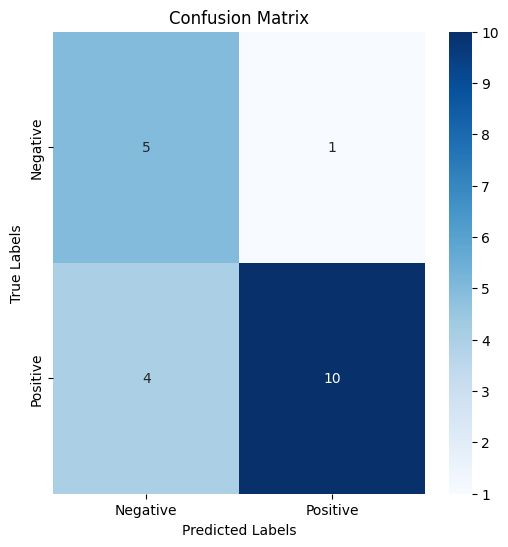

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Binary Classification Accuracy: 0.75
Binary Classification F1 Score: 0.8


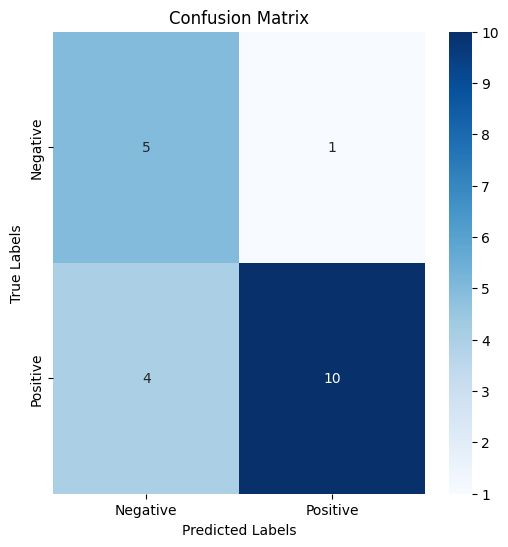

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Binary Classification Accuracy: 0.75
Binary Classification F1 Score: 0.8


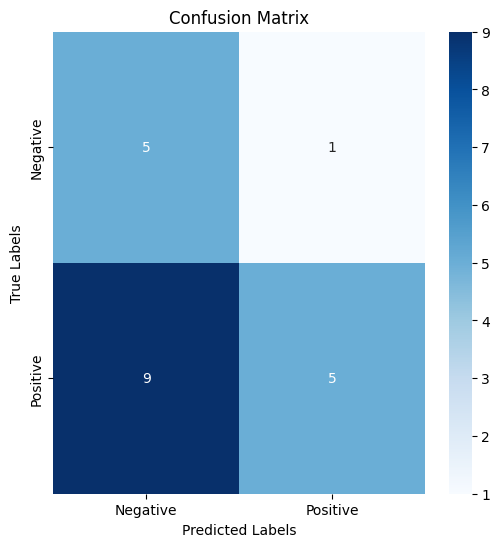

Binary Classification Accuracy: 0.5
Binary Classification F1 Score: 0.5


In [95]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from sklearn.model_selection import train_test_split

def bert_classifier_binary(texts, labels):
    # Initialize the sentiment-analysis pipeline
    classifier = pipeline("sentiment-analysis")

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.10, random_state=42)

    # Perform sentiment analysis
    results = classifier(X_test, truncation=True)

    # Map BERT's output to binary labels
    predictions = [0 if result['label'] == 'NEGATIVE' else 1 for result in results]

    # Calculate accuracy, confusion matrix, and F1 score
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    print(f"Binary Classification Accuracy: {accuracy}")
    print(f"Binary Classification F1 Score: {f1}")
    return accuracy, f1, cm

# Apply the function to different preprocessed texts
accuracy1, f1_1, cm1 = bert_classifier_binary(raw_text, labels)
accuracy2, f1_2, cm2 = bert_classifier_binary(raw_text_cleaned, labels)
accuracy3, f1_3, cm3 = bert_classifier_binary(final_processed_text, labels)

### BERT Pre-Trained Multiple Classification (Genre)

Our genre classification utilizes a BERT-based uncased model to distinguish text genres. This approach capitalizes on BERT's deep semantic understanding from uncased text, aiming for genre identification.

https://huggingface.co/google-bert/bert-base-uncased

In [96]:
def bert_classifier_multiple(texts, labels):
    # Encode labels
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(texts, encoded_labels, test_size=0.10, random_state=42)

    # Load a tokenizer and model suited for your multi-class task
    #tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    #tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    #model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(encoder.classes_))
    #model = AutoModelForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=len(encoder.classes_))
    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(encoder.classes_))

    # Initialize the pipeline
    classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

    # Perform classification
    results = classifier(X_test, truncation=True)

    # Decode predictions to original labels
    predictions = [int(result['label'].split('_')[-1]) for result in results]
    decoded_predictions = encoder.inverse_transform(predictions)

    # Calculate accuracy
    decoded_y_test = encoder.inverse_transform(y_test)
    accuracy = accuracy_score(decoded_y_test, decoded_predictions)
    print(f"Multi-class Classification Accuracy: {accuracy}")
    return accuracy


In [97]:
bert_classifier_multiple(final_processed_text, data["Genre of Movie"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Multi-class Classification Accuracy: 0.15


0.15

In [98]:
bert_classifier_multiple(raw_text, data["Genre of Movie"])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Multi-class Classification Accuracy: 0.4


0.4

In [99]:
bert_classifier_multiple(raw_text_cleaned, data["Genre of Movie"])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Multi-class Classification Accuracy: 0.1


0.1

Results for raw_text:


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Multi-class Classification Accuracy: 0.35
F1-Score: 0.1721014492753623


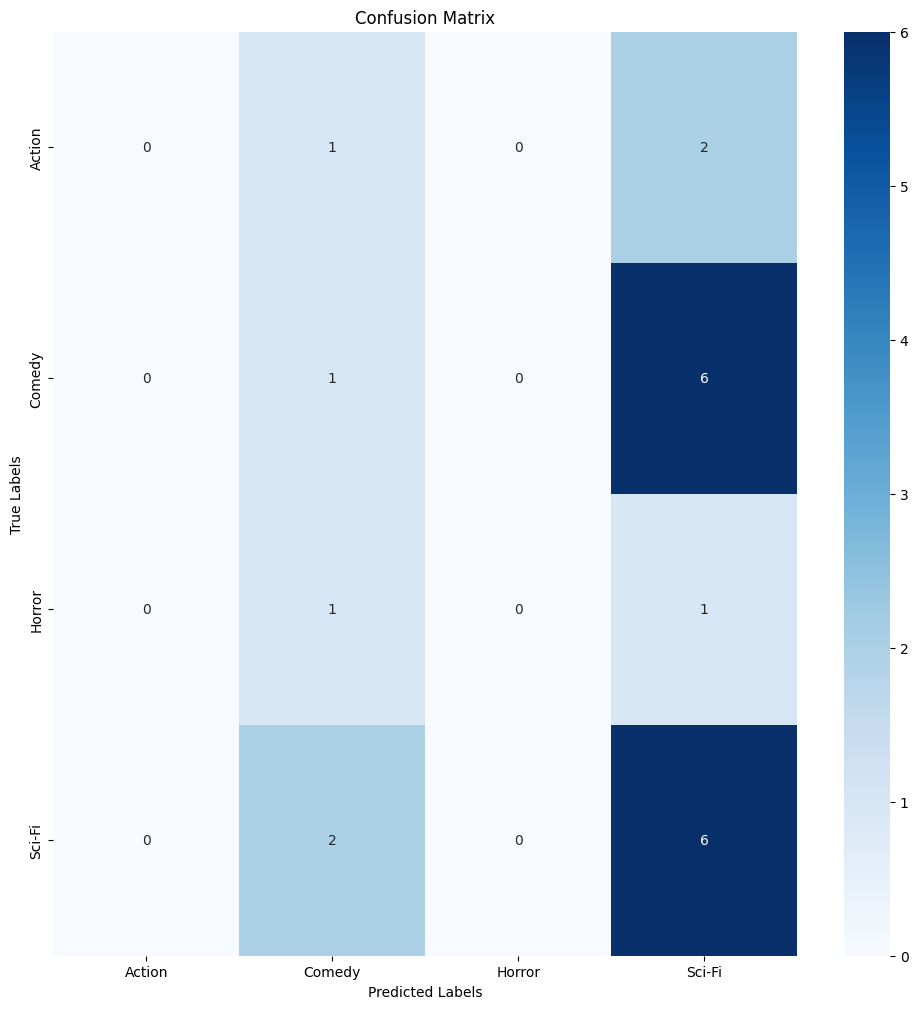

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results for raw_text_cleaned:
Multi-class Classification Accuracy: 0.15
F1-Score: 0.06521739130434782


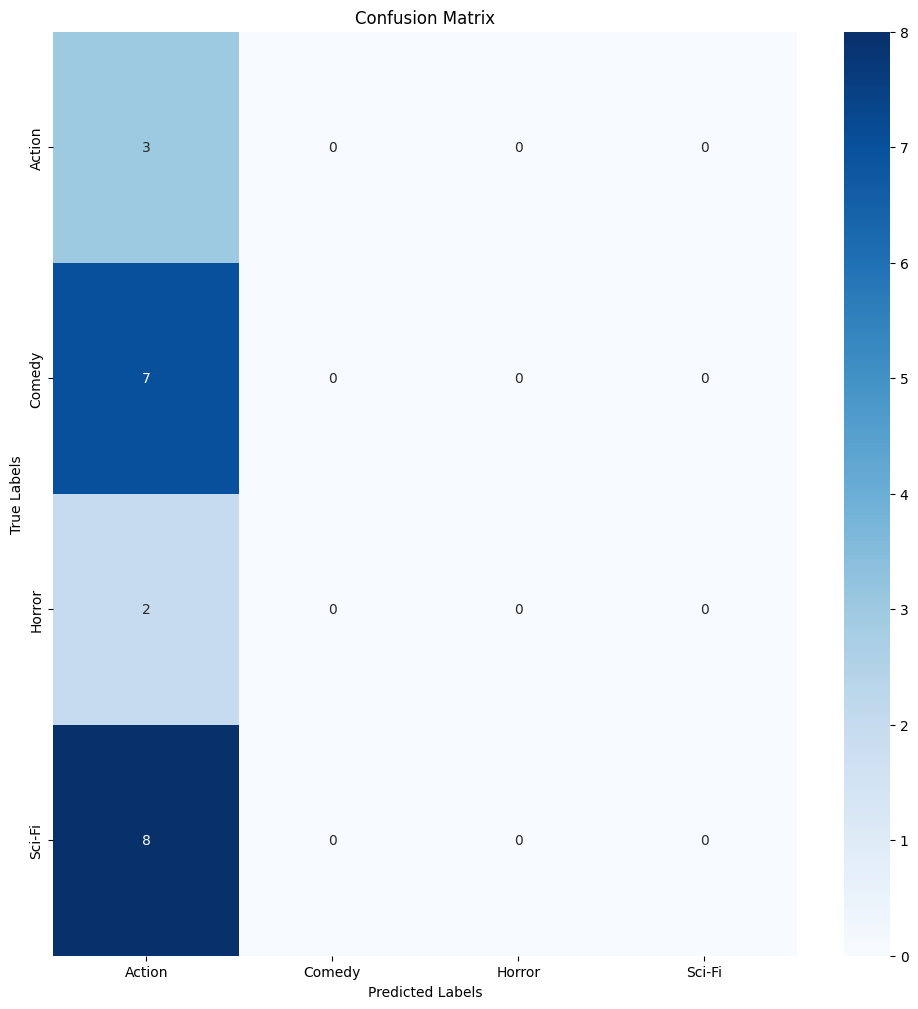

In [100]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Define the function for BERT classification
def bert_classifier_multiple(texts, labels):
    # Encode labels
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(texts, encoded_labels, test_size=0.10, random_state=42)

    # Load the tokenizer and model suited for your multi-class task
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(encoder.classes_))

    # Initialize the pipeline
    classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

    # Perform classification
    results = classifier(X_test, truncation=True)

    # Decode predictions to original labels
    predictions = [int(result['label'].split('_')[-1]) for result in results]
    decoded_predictions = encoder.inverse_transform(predictions)
    decoded_y_test = encoder.inverse_transform(y_test)

    # Calculate accuracy
    accuracy = accuracy_score(decoded_y_test, decoded_predictions)
    f1 = f1_score(decoded_y_test, decoded_predictions, average='macro')
    cm = confusion_matrix(decoded_y_test, decoded_predictions)

    print(f"Multi-class Classification Accuracy: {accuracy}")
    print(f"F1-Score: {f1}")

    return accuracy, f1, cm, encoder

# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

# Run BERT classification on raw_text
print("Results for raw_text:")
accuracy_raw, f1_raw, cm_raw, encoder_raw = bert_classifier_multiple(raw_text, data["Genre of Movie"])
plot_confusion_matrix(cm_raw, encoder_raw.classes_)

# Run BERT classification on raw_text_cleaned
print("Results for raw_text_cleaned:")
accuracy_cleaned, f1_cleaned, cm_cleaned, encoder_cleaned = bert_classifier_multiple(raw_text_cleaned, data["Genre of Movie"])
plot_confusion_matrix(cm_cleaned, encoder_cleaned.classes_)

### Confusion Matrix

This code snippet generates a confusion matrix to visually evaluate the performance of our classification model by comparing the actual versus predicted labels.

In [101]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

def bert_classifier_multiple(texts, labels):
    # Initialize and fit the label encoder
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(texts, encoded_labels, test_size=0.10, random_state=42)

    # Load a tokenizer and model suited for the multi-class task
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    #tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")

    model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(encoder.classes_))
    #model = AutoModelForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=len(encoder.classes_))

    # Initialize the pipeline
    classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

    # Perform classification
    results = classifier(X_test, truncation=True)

    # Process predictions
    predictions = [int(result['label'].split('_')[-1]) for result in results]

    # Decode predictions and true labels back to original labels
    decoded_predictions = encoder.inverse_transform(predictions)
    decoded_y_test = encoder.inverse_transform(y_test)

    # Return the true labels, predicted labels, and the encoder (for plotting confusion matrix)
    return decoded_y_test, decoded_predictions, encoder

# Assuming `data["Genre of Movie"]` is your labels array
true_labels, predicted_labels, encoder = bert_classifier_multiple(final_processed_text, data["Genre of Movie"])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


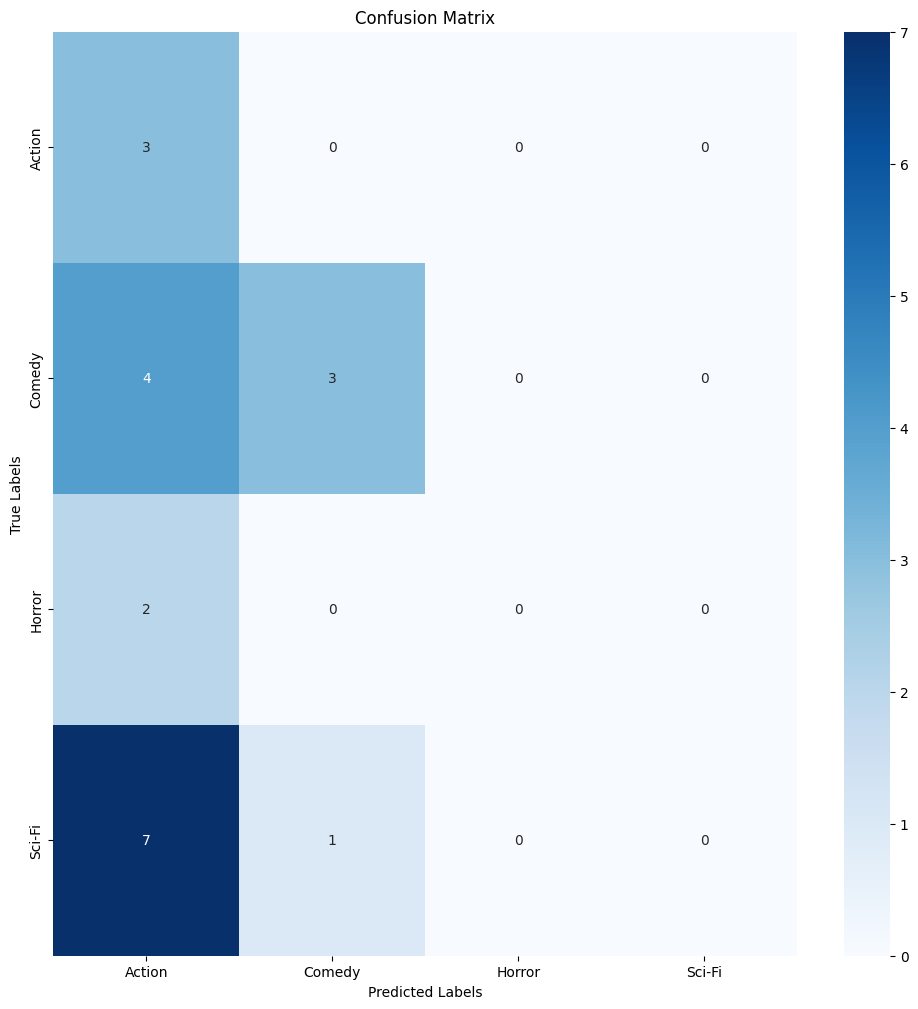

In [102]:
def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels, labels=classes)
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

plot_confusion_matrix(true_labels, predicted_labels, encoder.classes_)


In [103]:

from sklearn.metrics import confusion_matrix
import pandas as pd

def print_confusion_matrix(true_labels, predicted_labels, classes):
    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=classes)

    # Create a DataFrame from the confusion matrix
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(cm_df)

# Call the function with the true labels, predicted labels, and class names
print_confusion_matrix(true_labels, predicted_labels, encoder.classes_)


Confusion Matrix:
        Action  Comedy  Horror  Sci-Fi
Action       3       0       0       0
Comedy       4       3       0       0
Horror       2       0       0       0
Sci-Fi       7       1       0       0


In [104]:
#Part 2a
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# List of text versions to test
text_versions = {
    "Raw Text": raw_text,
    "Cleaned Text": raw_text_cleaned,
    "Final Processed Text": final_processed_text
}

# Labels (positive = 1, negative = 0)
y = labels

# Different vectorization methods
vectorizers = {
    "TF-IDF": TfidfVectorizer(),
    "BoW": CountVectorizer(),
}

# Different classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier()
}

# Loop through each text version
for text_name, X in text_versions.items():
    print(f"Evaluating Text Version: {text_name}")

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Loop through each vectorizer and classifier combination
    for vec_name, vectorizer in vectorizers.items():
        # Vectorize the training and test data
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)

        for clf_name, clf in classifiers.items():
            print(f"\nEvaluating {vec_name} + {clf_name} for {text_name}")

            # Train the classifier
            clf.fit(X_train_vec, y_train)

            # Make predictions
            y_pred = clf.predict(X_test_vec)

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            cm = confusion_matrix(y_test, y_pred)

            print(f"Accuracy: {accuracy:.4f}")
            print(f"F1-Score: {f1:.4f}")
            print("Confusion Matrix:")
            print(cm)
            print("-" * 50)

print("Experiment completed for all text versions, vectorizers, and classifiers.")

Evaluating Text Version: Raw Text

Evaluating TF-IDF + Logistic Regression for Raw Text
Accuracy: 0.5000
F1-Score: 0.5000
Confusion Matrix:
[[5 1]
 [9 5]]
--------------------------------------------------

Evaluating TF-IDF + SVM for Raw Text
Accuracy: 0.4000
F1-Score: 0.2500
Confusion Matrix:
[[ 6  0]
 [12  2]]
--------------------------------------------------

Evaluating TF-IDF + Random Forest for Raw Text
Accuracy: 0.4000
F1-Score: 0.4000
Confusion Matrix:
[[ 4  2]
 [10  4]]
--------------------------------------------------

Evaluating TF-IDF + Naive Bayes for Raw Text
Accuracy: 0.3000
F1-Score: 0.1250
Confusion Matrix:
[[ 5  1]
 [13  1]]
--------------------------------------------------

Evaluating TF-IDF + KNN for Raw Text
Accuracy: 0.3500
F1-Score: 0.4800
Confusion Matrix:
[[1 5]
 [8 6]]
--------------------------------------------------

Evaluating BoW + Logistic Regression for Raw Text
Accuracy: 0.6500
F1-Score: 0.7200
Confusion Matrix:
[[4 2]
 [5 9]]
----------------------

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


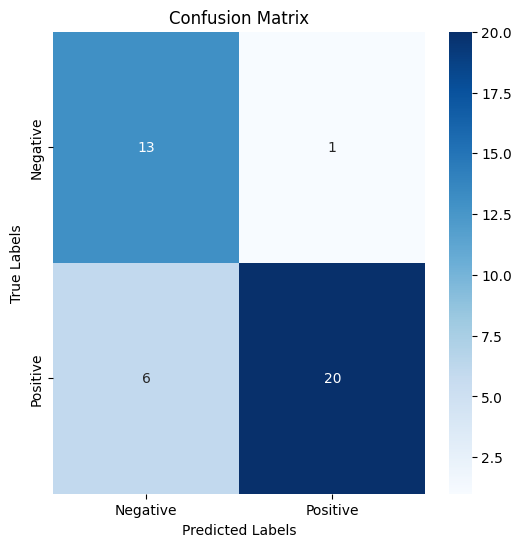

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Binary Classification Accuracy: 0.825
Binary Classification F1 Score: 0.851063829787234


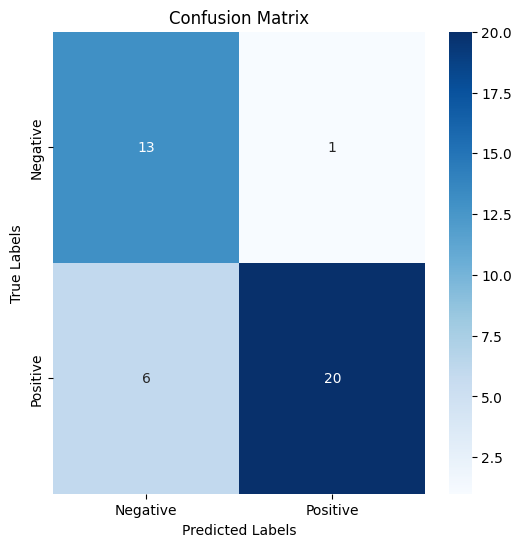

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Binary Classification Accuracy: 0.825
Binary Classification F1 Score: 0.851063829787234


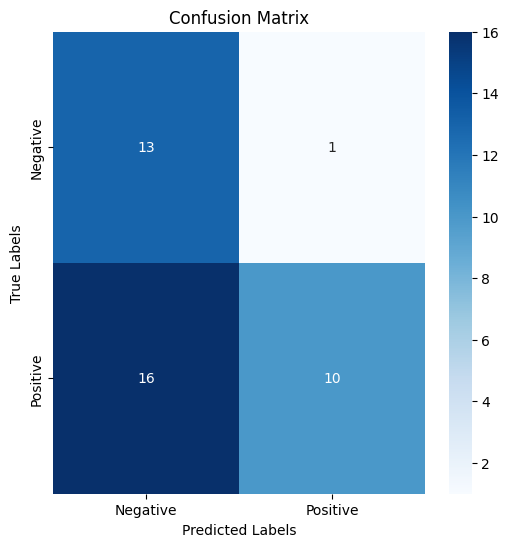

Binary Classification Accuracy: 0.575
Binary Classification F1 Score: 0.5405405405405406


In [107]:
#part 2b
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from sklearn.model_selection import train_test_split

# Define function for sentiment analysis with pre-trained BERT model
def bert_classifier_binary(texts, labels, test_split=0.2):
    # Initialize the sentiment-analysis pipeline
    classifier = pipeline("sentiment-analysis")

    # Split the dataset into train/test (consider adding validation if fine-tuning)
    X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=test_split, random_state=42)

    # Perform sentiment analysis
    results = classifier(X_test, truncation=True)

    # Map BERT's output to binary labels
    predictions = [0 if result['label'] == 'NEGATIVE' else 1 for result in results]

    # Calculate accuracy, confusion matrix, and F1 score
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    print(f"Binary Classification Accuracy: {accuracy}")
    print(f"Binary Classification F1 Score: {f1}")
    return accuracy, f1, cm

# Apply function to different versions of the text data for comparison
accuracy1, f1_1, cm1 = bert_classifier_binary(raw_text, labels)
accuracy2, f1_2, cm2 = bert_classifier_binary(raw_text_cleaned, labels)
accuracy3, f1_3, cm3 = bert_classifier_binary(final_processed_text, labels)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
23/23 [==============================] - 185s 7s/step - loss: 0.6992 - accuracy: 0.4389
Epoch 2/3
23/23 [==============================] - 174s 7s/step - loss: 0.6842 - accuracy: 0.5611
Epoch 3/3
3/3 [==============================] - 8s 1s/step - loss: 0.6987 - accuracy: 0.6000
Evaluation results: [0.6987284421920776, 0.6000000238418579]
3/3 [==============================] - 6s 1s/step
Accuracy: 0.6
F1 Score: 0.6666666666666666


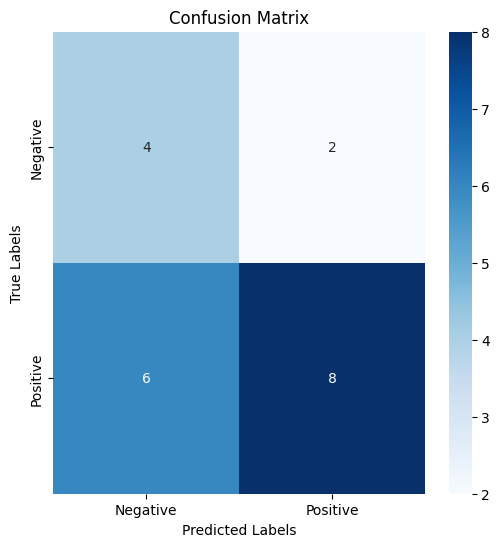

In [105]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the tokenizer and the DistilBERT model for TensorFlow
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Prepare dataset and labels
X = final_processed_text  # Choose your preferred preprocessed text
y = labels  # Sentiment labels: 1 for Positive, 0 for Negative

# Tokenize the data for TensorFlow
def tokenize_texts(texts, labels, max_length=128):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))
    return dataset

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Tokenize and batch the data
train_dataset = tokenize_texts(X_train, y_train).shuffle(100).batch(8)
test_dataset = tokenize_texts(X_test, y_test).batch(8)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train the model
model.fit(train_dataset, epochs=3)

# Evaluate the model
eval_results = model.evaluate(test_dataset)
print(f"Evaluation results: {eval_results}")

# Predict and evaluate with metrics
y_pred_logits = model.predict(test_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

# Generate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

Results for TF-IDF + Logistic Regression:
Accuracy: 1.0
F1-Score: 1.0
Confusion Matrix:
[[3 0 0 0]
 [0 7 0 0]
 [0 0 2 0]
 [0 0 0 8]]
--------------------------------------------------
Results for TF-IDF + SVM:
Accuracy: 1.0
F1-Score: 1.0
Confusion Matrix:
[[3 0 0 0]
 [0 7 0 0]
 [0 0 2 0]
 [0 0 0 8]]
--------------------------------------------------
Results for TF-IDF + Naive Bayes:
Accuracy: 1.0
F1-Score: 1.0
Confusion Matrix:
[[3 0 0 0]
 [0 7 0 0]
 [0 0 2 0]
 [0 0 0 8]]
--------------------------------------------------
Results for TF-IDF + Random Forest:
Accuracy: 1.0
F1-Score: 1.0
Confusion Matrix:
[[3 0 0 0]
 [0 7 0 0]
 [0 0 2 0]
 [0 0 0 8]]
--------------------------------------------------
Results for BoW + Logistic Regression:
Accuracy: 1.0
F1-Score: 1.0
Confusion Matrix:
[[3 0 0 0]
 [0 7 0 0]
 [0 0 2 0]
 [0 0 0 8]]
--------------------------------------------------
Results for BoW + SVM:
Accuracy: 1.0
F1-Score: 1.0
Confusion Matrix:
[[3 0 0 0]
 [0 7 0 0]
 [0 0 2 0]
 [0 0 0 8]]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
23/23 [==============================] - 352s 14s/step - loss: 1.4039 - accuracy: 0.2833
Epoch 2/3
23/23 [==============================] - 310s 14s/step - loss: 1.2735 - accuracy: 0.4500
Epoch 3/3
1/1 [==============================] - 14s 14s/step
Results for bert-base-uncased:
Accuracy: 0.8
F1-Score: 0.7940934065934067
Confusion Matrix:
[[3 0 0 0]
 [0 6 1 0]
 [0 0 2 0]
 [2 1 0 5]]


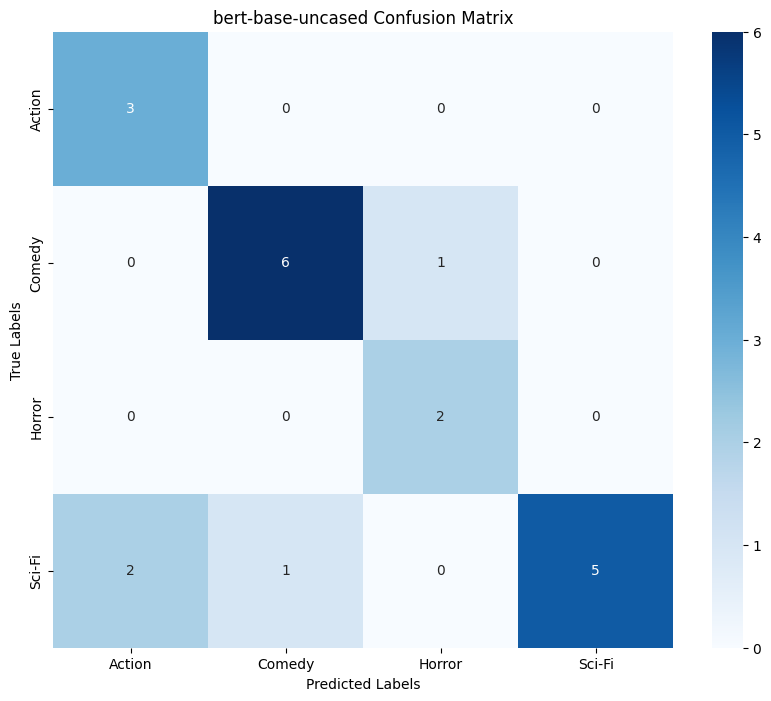

--------------------------------------------------


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
23/23 [==============================] - 178s 7s/step - loss: 1.3844 - accuracy: 0.2667
Epoch 2/3
23/23 [==============================] - 160s 7s/step - loss: 1.2365 - accuracy: 0.6556
Epoch 3/3
1/1 [==============================] - 9s 9s/step
Results for distilbert-base-uncased:
Accuracy: 0.8
F1-Score: 0.7428571428571429
Confusion Matrix:
[[3 0 0 0]
 [0 6 1 0]
 [0 1 1 0]
 [1 0 1 6]]


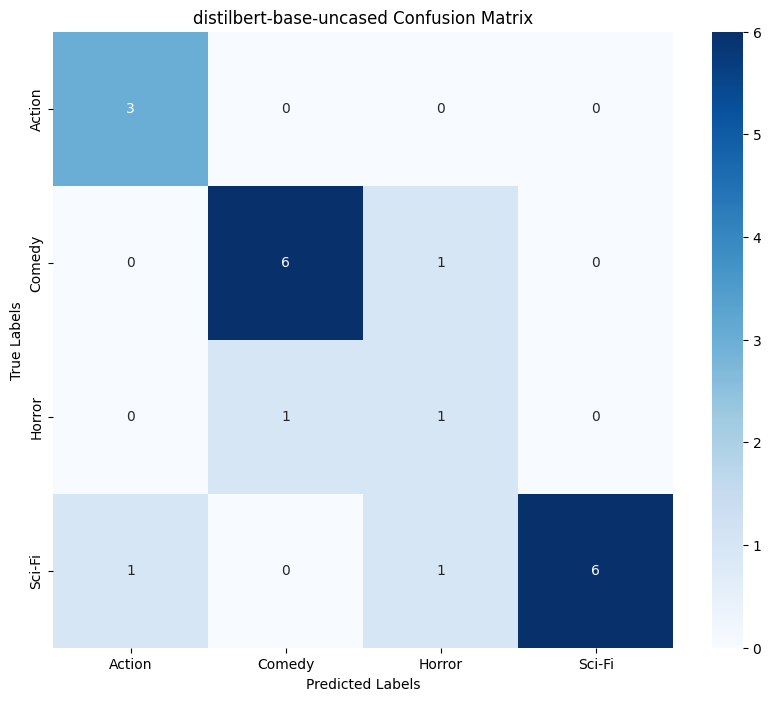

--------------------------------------------------
Method: TF-IDF + Logistic Regression
Accuracy: 1.0
F1 Score: 1.0
Confusion Matrix:
[[3 0 0 0]
 [0 7 0 0]
 [0 0 2 0]
 [0 0 0 8]]
Method: TF-IDF + SVM
Accuracy: 1.0
F1 Score: 1.0
Confusion Matrix:
[[3 0 0 0]
 [0 7 0 0]
 [0 0 2 0]
 [0 0 0 8]]
Method: TF-IDF + Naive Bayes
Accuracy: 1.0
F1 Score: 1.0
Confusion Matrix:
[[3 0 0 0]
 [0 7 0 0]
 [0 0 2 0]
 [0 0 0 8]]
Method: TF-IDF + Random Forest
Accuracy: 1.0
F1 Score: 1.0
Confusion Matrix:
[[3 0 0 0]
 [0 7 0 0]
 [0 0 2 0]
 [0 0 0 8]]
Method: BoW + Logistic Regression
Accuracy: 1.0
F1 Score: 1.0
Confusion Matrix:
[[3 0 0 0]
 [0 7 0 0]
 [0 0 2 0]
 [0 0 0 8]]
Method: BoW + SVM
Accuracy: 1.0
F1 Score: 1.0
Confusion Matrix:
[[3 0 0 0]
 [0 7 0 0]
 [0 0 2 0]
 [0 0 0 8]]
Method: BoW + Naive Bayes
Accuracy: 1.0
F1 Score: 1.0
Confusion Matrix:
[[3 0 0 0]
 [0 7 0 0]
 [0 0 2 0]
 [0 0 0 8]]
Method: BoW + Random Forest
Accuracy: 1.0
F1 Score: 1.0
Confusion Matrix:
[[3 0 0 0]
 [0 7 0 0]
 [0 0 2 0]
 [0 0 0 8

In [106]:
#part 3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, pipeline
import tensorflow as tf

# Prepare dataset and labels (Genres)
X = final_processed_text  # You may also try with raw_text or raw_text_cleaned
y = data["Genre of Movie"]

# Encode labels for multi-class classification
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.1, random_state=42)

# Define vectorizers and classifiers
vectorizers = {
    "TF-IDF": TfidfVectorizer(max_features=5000),
    "BoW": CountVectorizer(max_features=5000)
}

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "SVM": SVC(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# Initialize results dictionary
results = {}

# Experiment with different vectorizers and classifiers
for vec_name, vectorizer in vectorizers.items():
    # Vectorize the training and test data
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    for clf_name, clf in classifiers.items():
        # Train the classifier
        clf.fit(X_train_vec, y_train)

        # Make predictions
        y_pred = clf.predict(X_test_vec)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)

        # Store results
        results[f"{vec_name} + {clf_name}"] = {
            "accuracy": accuracy,
            "f1_score": f1,
            "confusion_matrix": cm
        }

        print(f"Results for {vec_name} + {clf_name}:")
        print(f"Accuracy: {accuracy}")
        print(f"F1-Score: {f1}")
        print(f"Confusion Matrix:\n{cm}")
        print("-" * 50)

# Plot confusion matrix function
def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

# Perform multi-class classification with pre-trained BERT models
bert_models = ["bert-base-uncased", "distilbert-base-uncased"]
for model_name in bert_models:
    # Load BERT model and tokenizer for TensorFlow
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(encoder.classes_))

    # Tokenize the data
    def tokenize_texts(texts):
        return tokenizer(
            texts, max_length=128, padding=True, truncation=True, return_tensors="tf"
        )

    X_train_tokens = tokenize_texts(X_train)
    X_test_tokens = tokenize_texts(X_test)

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    # Train the model
    model.fit(X_train_tokens.data, y_train, epochs=3, batch_size=8)

    # Make predictions on the test set
    y_pred_logits = model.predict(X_test_tokens.data).logits
    y_pred = np.argmax(y_pred_logits, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)

    # Store results
    results[model_name] = {
        "accuracy": accuracy,
        "f1_score": f1,
        "confusion_matrix": cm
    }

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy}")
    print(f"F1-Score: {f1}")
    print(f"Confusion Matrix:\n{cm}")
    plot_confusion_matrix(cm, encoder.classes_, title=f"{model_name} Confusion Matrix")
    print("-" * 50)

# Summary of all results
for method, metrics in results.items():
    print(f"Method: {method}")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"F1 Score: {metrics['f1_score']}")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")
    print("=" * 60)

Evaluating TF-IDF
TF-IDF | K=2, Inertia=187.28, Silhouette Score=0.012, Calinski-Harabasz Score=3.52
TF-IDF | K=3, Inertia=184.29, Silhouette Score=0.017, Calinski-Harabasz Score=3.37
TF-IDF | K=4, Inertia=181.61, Silhouette Score=0.020, Calinski-Harabasz Score=3.24
TF-IDF | K=5, Inertia=179.19, Silhouette Score=0.023, Calinski-Harabasz Score=3.10
TF-IDF | K=6, Inertia=174.27, Silhouette Score=0.037, Calinski-Harabasz Score=3.64
TF-IDF | K=7, Inertia=172.73, Silhouette Score=0.034, Calinski-Harabasz Score=3.33
TF-IDF | K=8, Inertia=169.20, Silhouette Score=0.044, Calinski-Harabasz Score=3.47
TF-IDF | K=9, Inertia=167.57, Silhouette Score=0.044, Calinski-Harabasz Score=3.28

Evaluating Word2Vec
Word2Vec | K=2, Inertia=8078.69, Silhouette Score=0.512, Calinski-Harabasz Score=292.18
Word2Vec | K=3, Inertia=5115.24, Silhouette Score=0.422, Calinski-Harabasz Score=286.62
Word2Vec | K=4, Inertia=3650.82, Silhouette Score=0.391, Calinski-Harabasz Score=292.58
Word2Vec | K=5, Inertia=3086.03, 

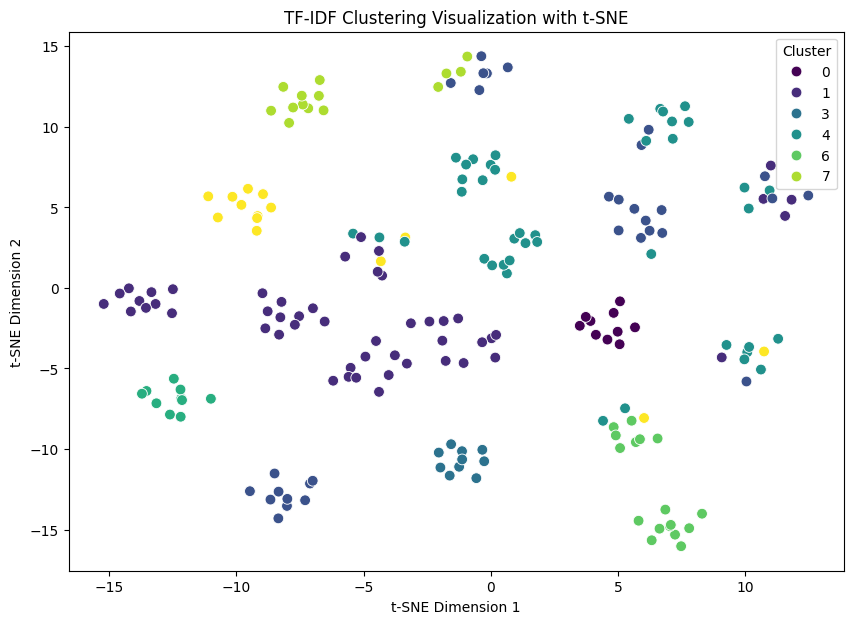

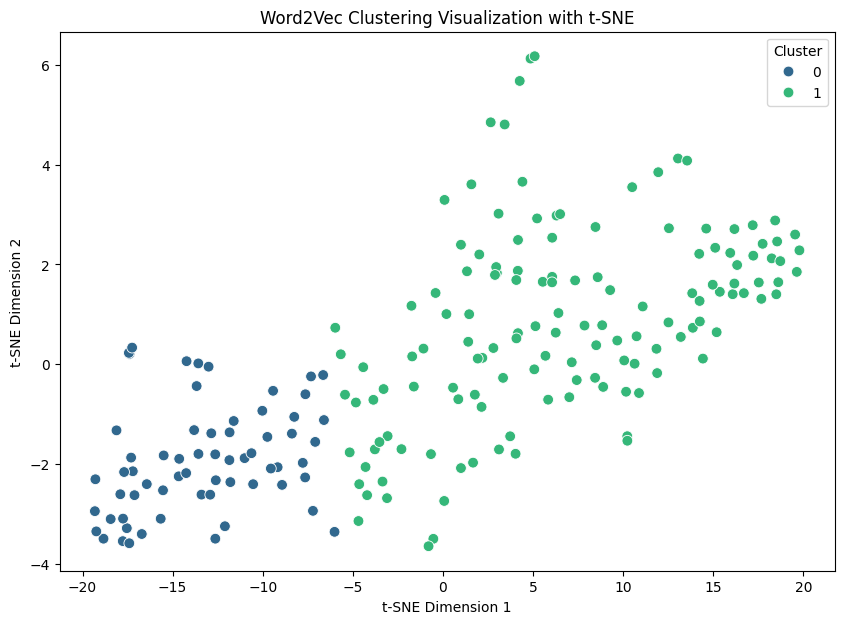


LSA with 2 Topics:
Topic 1:  movie barbie horror movies films character maverick action story batman
Topic 2:  barbie gerwig gosling barbies robbie margot barbieland greta mattel baumbach

LSA with 4 Topics:
Topic 1:  movie barbie horror movies films character maverick action story batman
Topic 2:  barbie gerwig gosling barbies robbie margot barbieland greta mattel girls
Topic 3:  maverick mavericks aerial feels goose emotional action iceman barbie combat
Topic 4:  batman pattinson wayne reeves bruce gotham riddler robert alfred knight

LDA with 2 Topics:
Topic 1:  movie girls scott films character school daughter characters world comedy
Topic 2:  movie story barbie movies films horror batman action world character

LDA with 4 Topics:
Topic 1:  scott pennywise chapter black world characters losers pitch movie pilgrim
Topic 2:  batman movie kingsman action movies films characters thats oblivion world
Topic 3:  movie barbie horror movies story people world really scary house
Topic 4:  m

In [112]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler

# Corpus: Use all texts
texts = final_processed_text  # Adjust this if using multiple processed texts

# Define TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(texts).toarray()

# Train Word2Vec Model on all texts for Word2Vec embedding
w2v_model = Word2Vec(sentences=[text.split() for text in texts], vector_size=100, window=5, min_count=1, sg=1)
word2vec_vectors = []
for text in texts:
    words = text.split()
    vector = np.mean([w2v_model.wv[word] for word in words if word in w2v_model.wv], axis=0)
    word2vec_vectors.append(vector)
word2vec_matrix = np.array(word2vec_vectors)
word2vec_matrix = StandardScaler().fit_transform(word2vec_matrix)

# Define range of k values
k_values = range(2, 10)

def evaluate_clustering(matrix, method_name):
    """Perform clustering on a given matrix and evaluate with KMeans for each k in k_values."""
    results = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(matrix)
        inertia = kmeans.inertia_
        silhouette = silhouette_score(matrix, kmeans.labels_)
        ch_score = calinski_harabasz_score(matrix, kmeans.labels_)
        results.append((k, inertia, silhouette, ch_score))
        print(f"{method_name} | K={k}, Inertia={inertia:.2f}, Silhouette Score={silhouette:.3f}, Calinski-Harabasz Score={ch_score:.2f}")
    return pd.DataFrame(results, columns=['K', 'Inertia', 'Silhouette', 'Calinski-Harabasz'])

print("Evaluating TF-IDF")
tfidf_results = evaluate_clustering(tfidf_matrix, "TF-IDF")

print("\nEvaluating Word2Vec")
word2vec_results = evaluate_clustering(word2vec_matrix, "Word2Vec")

# Choose the best k based on highest silhouette score for both methods
best_k_tfidf = tfidf_results.loc[tfidf_results['Silhouette'].idxmax(), 'K']
best_k_word2vec = word2vec_results.loc[word2vec_results['Silhouette'].idxmax(), 'K']
print(f"\nBest k for TF-IDF: {best_k_tfidf}")
print(f"Best k for Word2Vec: {best_k_word2vec}")

# Visualize clusters using t-SNE for both TF-IDF and Word2Vec
def plot_clusters(matrix, labels, method_name):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(matrix)
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette="viridis", s=60)
    plt.title(f"{method_name} Clustering Visualization with t-SNE")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(title="Cluster")
    plt.show()

# Clustering with optimal k and plotting for TF-IDF
kmeans_tfidf = KMeans(n_clusters=best_k_tfidf, random_state=42)
tfidf_labels = kmeans_tfidf.fit_predict(tfidf_matrix)
plot_clusters(tfidf_matrix, tfidf_labels, "TF-IDF")

# Clustering with optimal k and plotting for Word2Vec
kmeans_word2vec = KMeans(n_clusters=best_k_word2vec, random_state=42)
word2vec_labels = kmeans_word2vec.fit_predict(word2vec_matrix)
plot_clusters(word2vec_matrix, word2vec_labels, "Word2Vec")

# Topic Modeling with LSA and LDA
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}: ", " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# LSA with TF-IDF Matrix
print("\nLSA with 2 Topics:")
lsa_2 = TruncatedSVD(n_components=2, random_state=42)
lsa_2_topics = lsa_2.fit_transform(tfidf_matrix)
display_topics(lsa_2, tfidf_vectorizer.get_feature_names_out())

print("\nLSA with 4 Topics:")
lsa_4 = TruncatedSVD(n_components=4, random_state=42)
lsa_4_topics = lsa_4.fit_transform(tfidf_matrix)
display_topics(lsa_4, tfidf_vectorizer.get_feature_names_out())

# LDA with Count Vectorizer Matrix
print("\nLDA with 2 Topics:")
count_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
count_matrix = count_vectorizer.fit_transform(texts).toarray()

lda_2 = LatentDirichletAllocation(n_components=2, random_state=42)
lda_2_topics = lda_2.fit_transform(count_matrix)
display_topics(lda_2, count_vectorizer.get_feature_names_out())

print("\nLDA with 4 Topics:")
lda_4 = LatentDirichletAllocation(n_components=4, random_state=42)
lda_4_topics = lda_4.fit_transform(count_matrix)
display_topics(lda_4, count_vectorizer.get_feature_names_out())

Evaluating TF-IDF
TF-IDF | K=2, Inertia=560.00, Silhouette Score=0.018, Calinski-Harabasz Score=10.27
TF-IDF | K=3, Inertia=551.09, Silhouette Score=0.025, Calinski-Harabasz Score=10.03
TF-IDF | K=4, Inertia=542.98, Silhouette Score=0.031, Calinski-Harabasz Score=9.75
TF-IDF | K=5, Inertia=532.67, Silhouette Score=0.041, Calinski-Harabasz Score=10.32
TF-IDF | K=6, Inertia=521.70, Silhouette Score=0.050, Calinski-Harabasz Score=10.91
TF-IDF | K=7, Inertia=512.59, Silhouette Score=0.058, Calinski-Harabasz Score=10.99
TF-IDF | K=8, Inertia=509.30, Silhouette Score=0.059, Calinski-Harabasz Score=10.02
TF-IDF | K=9, Inertia=499.95, Silhouette Score=0.068, Calinski-Harabasz Score=10.29

Evaluating Word2Vec
Word2Vec | K=2, Inertia=41240.70, Silhouette Score=0.339, Calinski-Harabasz Score=272.01
Word2Vec | K=3, Inertia=33169.76, Silhouette Score=0.288, Calinski-Harabasz Score=241.45
Word2Vec | K=4, Inertia=28618.18, Silhouette Score=0.296, Calinski-Harabasz Score=217.85
Word2Vec | K=5, Inertia

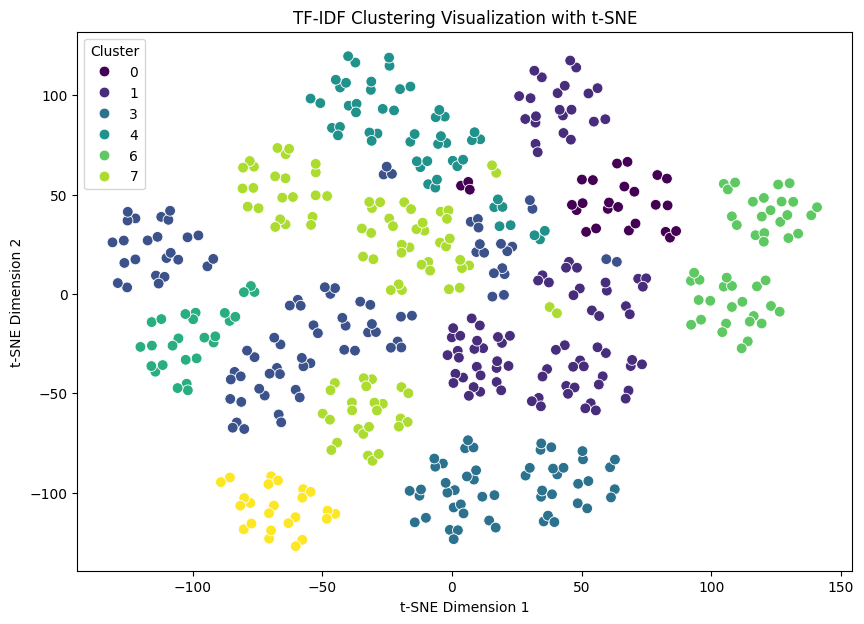

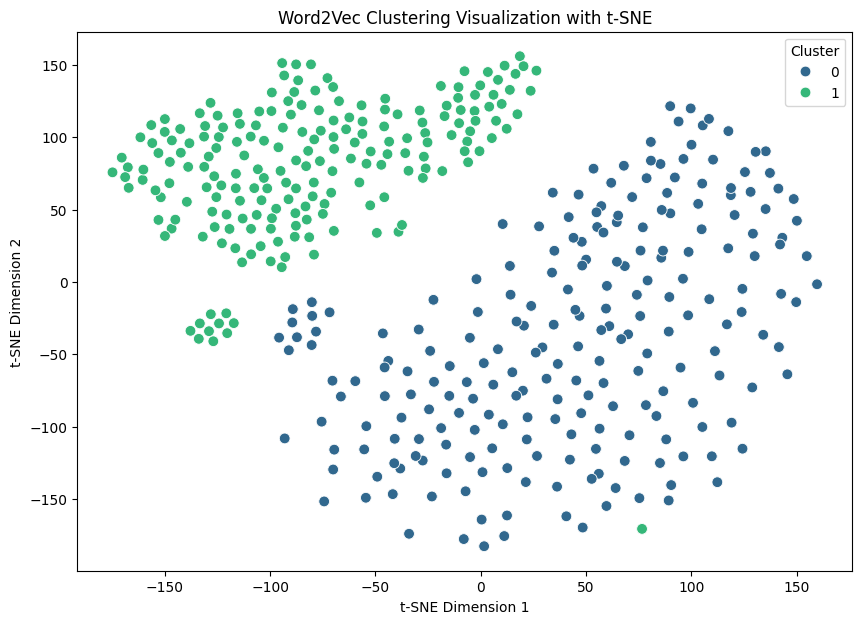

In [113]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler

# Flatten the corpus to include all texts in a single list
texts = raw_text + raw_text_cleaned + final_processed_text

# Define TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(texts).toarray()  # Convert to dense array

# Train Word2Vec Model on all texts for Word2Vec embedding
w2v_model = Word2Vec(sentences=[text.split() for text in texts], vector_size=100, window=5, min_count=1, sg=1)
word2vec_vectors = []
for text in texts:
    words = text.split()
    vector = np.mean([w2v_model.wv[word] for word in words if word in w2v_model.wv], axis=0)
    word2vec_vectors.append(vector)
word2vec_matrix = np.array(word2vec_vectors)
word2vec_matrix = StandardScaler().fit_transform(word2vec_matrix)

# Define range of k values
k_values = range(2, 10)

def evaluate_clustering(matrix, method_name):
    """Perform clustering on a given matrix and evaluate with KMeans for each k in k_values."""
    results = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(matrix)

        # Calculate metrics
        inertia = kmeans.inertia_
        silhouette = silhouette_score(matrix, kmeans.labels_)
        ch_score = calinski_harabasz_score(matrix, kmeans.labels_)

        results.append((k, inertia, silhouette, ch_score))
        print(f"{method_name} | K={k}, Inertia={inertia:.2f}, Silhouette Score={silhouette:.3f}, Calinski-Harabasz Score={ch_score:.2f}")

    return pd.DataFrame(results, columns=['K', 'Inertia', 'Silhouette', 'Calinski-Harabasz'])

# Evaluate and store results for both TF-IDF and Word2Vec
print("Evaluating TF-IDF")
tfidf_results = evaluate_clustering(tfidf_matrix, "TF-IDF")

print("\nEvaluating Word2Vec")
word2vec_results = evaluate_clustering(word2vec_matrix, "Word2Vec")

# Choose the best k based on highest silhouette score for both methods
best_k_tfidf = tfidf_results.loc[tfidf_results['Silhouette'].idxmax(), 'K']
best_k_word2vec = word2vec_results.loc[word2vec_results['Silhouette'].idxmax(), 'K']
print(f"\nBest k for TF-IDF: {best_k_tfidf}")
print(f"Best k for Word2Vec: {best_k_word2vec}")

# Visualize clusters using t-SNE for both TF-IDF and Word2Vec
def plot_clusters(matrix, labels, method_name):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(matrix)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette="viridis", s=60)
    plt.title(f"{method_name} Clustering Visualization with t-SNE")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(title="Cluster")
    plt.show()

# Clustering with optimal k and plotting for TF-IDF
kmeans_tfidf = KMeans(n_clusters=best_k_tfidf, random_state=42)
tfidf_labels = kmeans_tfidf.fit_predict(tfidf_matrix)
plot_clusters(tfidf_matrix, tfidf_labels, "TF-IDF")

# Clustering with optimal k and plotting for Word2Vec
kmeans_word2vec = KMeans(n_clusters=best_k_word2vec, random_state=42)
word2vec_labels = kmeans_word2vec.fit_predict(word2vec_matrix)
plot_clusters(word2vec_matrix, word2vec_labels, "Word2Vec")